In [1]:
# продолжаем работу с MLP, как в mlp.ipynb
# для сложный нейросетей иногда трудно получить хорошую оптимизацию, они могут быть плохо оптимизируемыми
# для понимания, почему так происходит, нужно погружиться в то, что происходит с активациями и градиентами

# Скопируем загрузку данных и построение датасета из прошлого ноутбука mlp.ipynb

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [4]:
# построим словарь отображения из букв в индексы
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
# и наоборот
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# построим датасет
block_size = 3  # длина контекста: сколько букв учитывать при предсказании следующей буквы

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # обрезаем и добавляем
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Снова посетим MLP

In [6]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)  # embeddings
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g)  # weights of 1 layer
b1 = torch.randn(n_hidden , generator=g)  # bias of 1 layer
W2 = torch.randn((n_hidden, vocab_size) , generator=g)  # weights of 2 layer
b2 = torch.randn(vocab_size , generator=g)  # bias of 2 layer

parameters = [C, W1, b1, W2, b2]  # all the parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [7]:
# такая же оптимизация как в нотбуке mlp.ipynb
max_steps = 200000
batch_size = 32
lossi = []

lr = 0.1
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # иногда делают обрезание learning rate после определенного количества итераций
    lr = 0.1 if i < 100000 else 0.01  
    
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/ 200000: 26.0264
  10000/ 200000: 2.5922
  20000/ 200000: 2.2396
  30000/ 200000: 2.1972
  40000/ 200000: 2.3131
  50000/ 200000: 2.6144
  60000/ 200000: 2.7436
  70000/ 200000: 2.6346
  80000/ 200000: 2.3224
  90000/ 200000: 2.1494
 100000/ 200000: 2.6736
 110000/ 200000: 2.2784
 120000/ 200000: 2.0382
 130000/ 200000: 1.9361
 140000/ 200000: 2.1771
 150000/ 200000: 1.9038
 160000/ 200000: 2.1977
 170000/ 200000: 2.1539
 180000/ 200000: 1.9471
 190000/ 200000: 2.2010


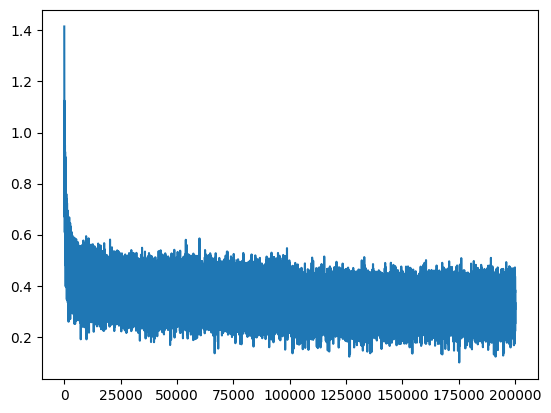

In [8]:
plt.plot(lossi);

In [9]:
@torch.no_grad()  # декоратор отключает отслеживание градиентов
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.138702869415283
val 2.1777729988098145


In [10]:
# генерация моделью

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # сначала у нас только фиктивные буквы "..."
    while True:
        emb = C[torch.tensor([context])]  # [1, block_size, embd]
        embcat = emb.view(emb.shape[0], -1)  # [1, embd*block_size]
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)  # [1, hidden_size]
        logits = h @ W2 + b2  # [1, vocab_size]
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mora.
kayah.
see.
mad.
rylee.
emmadiendrlee.
adee.
daelin.
shy.
jen.
eden.
estanar.
kayzion.
kamin.
shubergiaganel.
janie.
jelinn.
broor.
uzmethe.
ryyah.


# Проблема с инициализацией

In [11]:
# в начале обучения можно видеть большой лосс для необученной модели
# для букв логично, что в начале я не ожидаю встретить какую-либо букву следующей сильнее других
# мы ожидаем чего-то равномерного, все буквы равны по вероятности
expected_p = torch.tensor(1/27.0)  # 27 букв
expected_loss = -expected_p.log()  # ожидаемый лосс для необученной модели
expected_loss

tensor(3.2958)

In [12]:
# 4-х мерный пример такой проблемы
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [13]:
# что произойдет, если у нас логиты будут случайно выше или ниже
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(probs, loss)  # отлично угадали, низкий лосс!

logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(probs, loss)  # вообще не угадали, очень высокий лосс!

tensor([0.0066, 0.0066, 0.9802, 0.0066]) tensor(0.0200)
tensor([0.0066, 0.9802, 0.0066, 0.0066]) tensor(5.0200)


In [14]:
# если инициализовать случайно нормально
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(probs, loss)  # в целом стабильный, не очень большой

logits = torch.randn(4) * 100
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(probs, loss)  # а теперь значения очень скачут, лосс ломается (перезапустить ячейку несколько раз и сравниить результаты)

tensor([0.0384, 0.5389, 0.1699, 0.2528]) tensor(1.7725)
tensor([2.2421e-43, 0.0000e+00, 1.0000e+00, 0.0000e+00]) tensor(-0.)


In [15]:
# что же происходит с нашей инциализацией сети?
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)  # embeddings
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g)  # weights of 1 layer
b1 = torch.randn(n_hidden , generator=g)  # bias of 1 layer
W2 = torch.randn((n_hidden, vocab_size) , generator=g)  # weights of 2 layer
b2 = torch.randn(vocab_size , generator=g)  # bias of 2 layer

parameters = [C, W1, b1, W2, b2]  # all the parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

# такая же оптимизация как в нотбуке mlp.ipynb
max_steps = 200000
batch_size = 32
lossi = []

lr = 0.1
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # иногда делают обрезание learning rate после определенного количества итераций
    lr = 0.1 if i < 100000 else 0.01  
    
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    break  # смотрим на первую итерацию

11897
      0/ 200000: 30.2380


In [16]:
logits[0]  # логиты сильно раскиданы

tensor([  0.1576,  -2.3268,  -9.4740,  -6.7461,  13.7372, -10.4907,  -5.7905,
         10.7337,  14.0784,   4.3245,   1.9208, -14.9805,  14.0306, -10.9357,
          6.7341,   8.2830, -10.7423,  -4.5829, -14.5833, -16.0124,   7.2890,
         21.8017,  -3.0413, -20.3502,   5.5049, -13.1844,  -6.8645],
       grad_fn=<SelectBackward0>)

In [17]:
# но как они считаются? если посмотреть на подсчет логитов, то logits = h @ W2 + b2, то есть мы добавляем еще случайный bias к случайным числам
# это не очень хорошо, кроме того, еще умножаем на матрицу W2
# попробуем занулить b2 и уменьшить W2
# что же происходит с нашей инциализацией сети?
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)  # embeddings
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g)  # weights of 1 layer
b1 = torch.randn(n_hidden , generator=g)  # bias of 1 layer
W2 = torch.randn((n_hidden, vocab_size) , generator=g) * 0.01  # weights of 2 layer, уменьшаем
b2 = torch.randn(vocab_size , generator=g) * 0  # bias of 2 layer, зануляем

parameters = [C, W1, b1, W2, b2]  # all the parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

# такая же оптимизация как в нотбуке mlp.ipynb
max_steps = 200000
batch_size = 32
lossi = []

lr = 0.1
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # иногда делают обрезание learning rate после определенного количества итераций
    lr = 0.1 if i < 100000 else 0.01  
    
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    break  # смотрим на первую итерацию

11897
      0/ 200000: 3.3201


In [18]:
logits[0]  # логиты стали ближе к нулю и больше друг на друга похожи

tensor([-0.0819, -0.0131,  0.1456, -0.1342, -0.1164,  0.0502, -0.1307, -0.0484,
        -0.1799,  0.1829,  0.0787,  0.0450,  0.1282, -0.1744,  0.0023,  0.2763,
        -0.0244, -0.0604,  0.1481,  0.3055, -0.2393,  0.0628, -0.1124,  0.0813,
         0.1642, -0.1363,  0.2313], grad_fn=<SelectBackward0>)

In [19]:
# если мы поставим W2 вообще нулями, то мы придем в желаемую ситуацию с идеальным начальным лоссом
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)  # embeddings
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g)  # weights of 1 layer
b1 = torch.randn(n_hidden , generator=g)  # bias of 1 layer
W2 = torch.randn((n_hidden, vocab_size) , generator=g) * 0  # weights of 2 layer, зануляем
b2 = torch.randn(vocab_size , generator=g) * 0  # bias of 2 layer, зануляем

parameters = [C, W1, b1, W2, b2]  # all the parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

# такая же оптимизация как в нотбуке mlp.ipynb
max_steps = 200000
batch_size = 32
lossi = []

lr = 0.1
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # иногда делают обрезание learning rate после определенного количества итераций
    lr = 0.1 if i < 100000 else 0.01  
    
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    break  # смотрим на первую итерацию

11897
      0/ 200000: 3.2958


In [20]:
logits[0]  # логиты стали нулями

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], grad_fn=<SelectBackward0>)

In [21]:
# ситуация конечно идеальная в плане лосса, но лучше оставить их просто маленькими значениями
# может быть для выходного слоя можно и нулями, но здесь может возниктуть проблема, о которой будет ниже

In [22]:
# попробуем теперь обучить с новой инициализацией и посмотрим каким будет лосс

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)  # embeddings
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g)  # weights of 1 layer
b1 = torch.randn(n_hidden , generator=g)  # bias of 1 layer
W2 = torch.randn((n_hidden, vocab_size) , generator=g) * 0.01  # weights of 2 layer, уменьшаем
b2 = torch.randn(vocab_size , generator=g) * 0  # bias of 2 layer, зануляем

parameters = [C, W1, b1, W2, b2]  # all the parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

lr = 0.1
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # иногда делают обрезание learning rate после определенного количества итераций
    lr = 0.1 if i < 100000 else 0.01  
    
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

11897
      0/ 200000: 3.3320
  10000/ 200000: 2.6205
  20000/ 200000: 2.4978
  30000/ 200000: 2.0358
  40000/ 200000: 2.2351
  50000/ 200000: 2.6330
  60000/ 200000: 2.0159
  70000/ 200000: 2.3640
  80000/ 200000: 2.1317
  90000/ 200000: 2.2989
 100000/ 200000: 2.0787
 110000/ 200000: 2.2468
 120000/ 200000: 2.0972
 130000/ 200000: 2.2214
 140000/ 200000: 2.2111
 150000/ 200000: 2.3496
 160000/ 200000: 2.2122
 170000/ 200000: 2.0975
 180000/ 200000: 2.3621
 190000/ 200000: 2.0815


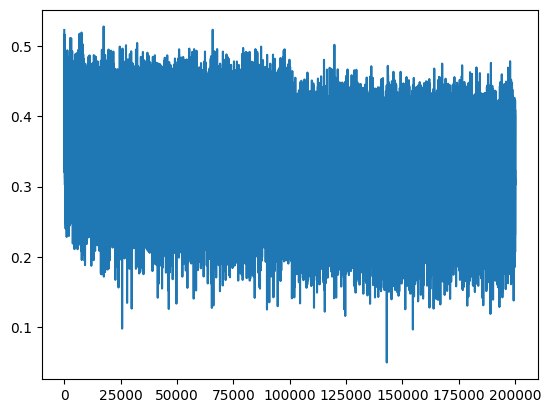

In [23]:
plt.plot(lossi)

In [24]:
# получаем даже немного лучший результат, это происходит потому, что нейросеть в действительности тратит больше итераций на обучение
# а не на то, чтобы сначала сжать веса и сделать выходы равномерными из-за большой инициализации весов
split_loss('train')
split_loss('val')

train 2.0709221363067627
val 2.1333775520324707


## Проблема с tanh

In [25]:
# Несмотря на то, что инциализация помогла улучшить лосс, осталась скрытая проблема, она заключается в tanh

In [26]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)  # embeddings
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g)  # weights of 1 layer
b1 = torch.randn(n_hidden , generator=g)  # bias of 1 layer
W2 = torch.randn((n_hidden, vocab_size) , generator=g) * 0.01  # weights of 2 layer, уменьшаем
b2 = torch.randn(vocab_size , generator=g) * 0  # bias of 2 layer, зануляем

parameters = [C, W1, b1, W2, b2]  # all the parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

lr = 0.1
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # иногда делают обрезание learning rate после определенного количества итераций
    lr = 0.1 if i < 100000 else 0.01  
    
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    
    break

11897
      0/ 200000: 3.3111


In [27]:
h  # много значений в -1 и 1

tensor([[ 0.8837, -0.1454, -1.0000,  ...,  0.8293, -0.7937,  0.9823],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-0.9974, -1.0000, -1.0000,  ...,  0.9999,  0.8388, -0.9998],
        ...,
        [-0.9999, -1.0000, -0.9999,  ...,  1.0000, -1.0000, -0.9998],
        [-0.9999,  0.8271,  0.9367,  ..., -0.9994,  1.0000,  1.0000],
        [ 1.0000, -0.9978,  0.9860,  ...,  0.9765, -1.0000, -0.9761]],
       grad_fn=<TanhBackward0>)

In [28]:
h.shape

torch.Size([32, 200])

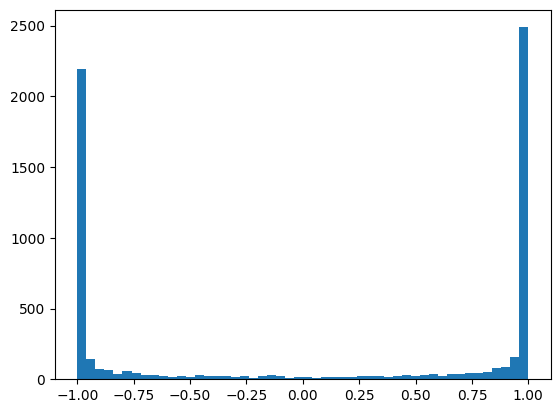

In [29]:
plt.hist(h.view(-1).tolist(), bins=50);  # сделаем из активаций вектор и превратим его в список, чтобы построить гистограмму значений
# видно, что тангенс очень активен 

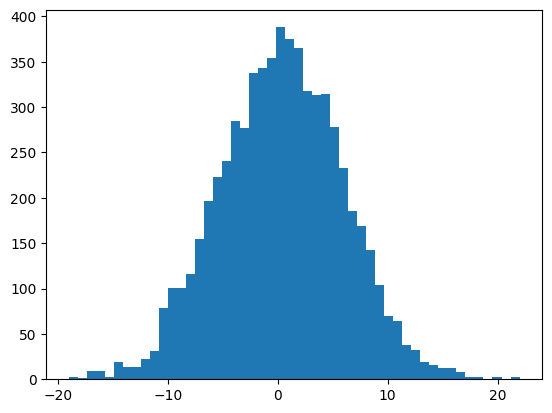

In [30]:
# почему так произошло? давайте посмотрим на то, что попадает на вход тангенсу
plt.hist(hpreact.view(-1).tolist(), bins=50);
# много больших значений

In [31]:
# это может и не выглядеть большой проблемой, пока мы не задумаемся над тем, как градиенты будут протекать через такую историю
# посмотрим как градиент протечет через tanh
# производная tanh = (1-tanh^2), что будет если сюда попадет значение -1 или 1? будет градиент = 0
# на этом этапе мы просто убьем весь градиент сети и получится так, что веса нижних слоев никак не будут влиять на лосс

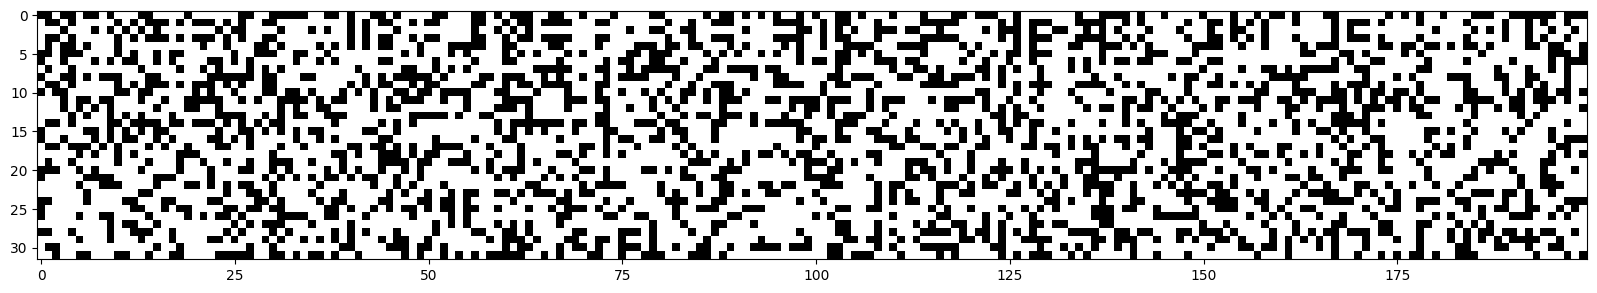

In [32]:
# сколько градиентов убивается тангенсом
# белые - те точки, в которых тангенс близок к 1 или -1
# проблема будет для нас тогда, когда мы увидим полностью белую колонку, значит ни одно значение не может пройти сквозь тангес - это мертвый нейрон
# то есть любой вход может пройти через нейрон и градиент никакой по этому входу не вернется, значит нейрон не будет учиться
# никакое входное значение не активирует нейрон, он всегда 1 или всегда -1
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');
# на данной картине мы не видим колонок, полностью белых, значит мертвых нейронов нет и они что-то да учат

In [33]:
# такая ситуация может произойти для других функций активации тоже, которые имеют плоские концы (1 или 2)
# например, сигмоида, сжимает также значения, или релу, имеет область постоянных нулей
# при инициализации может произойти отмирание случайно, а также и при обучении, когда нейрон получает большие градиенты и просто выбивается и умирает

In [34]:
# в нашем случае нет полностью белых колонок, но тем не менее - это нежеланная картинка, особенно на первой итерации
# которая зависит от входа в тангенс, который получился с достаточно большими значениями
# которые зависят от инициализации!

In [35]:
# как можем это починить? аналогично, hpreact = embcat @ W1 + b1, значит инициализация С и W1 и b1

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)  # embeddings
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g) * 0.1  # weights of 1 layer, уменьшим их немного
b1 = torch.randn(n_hidden , generator=g) * 0.01  # bias of 1 layer, уменьшим, но не в 0, чтобы оставить немного энтропии
W2 = torch.randn((n_hidden, vocab_size) , generator=g) * 0.01  # weights of 2 layer, уменьшаем
b2 = torch.randn(vocab_size , generator=g) * 0  # bias of 2 layer, зануляем

parameters = [C, W1, b1, W2, b2]  # all the parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

lr = 0.1
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # иногда делают обрезание learning rate после определенного количества итераций
    lr = 0.1 if i < 100000 else 0.01  
    
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    
    break

11897
      0/ 200000: 3.2936


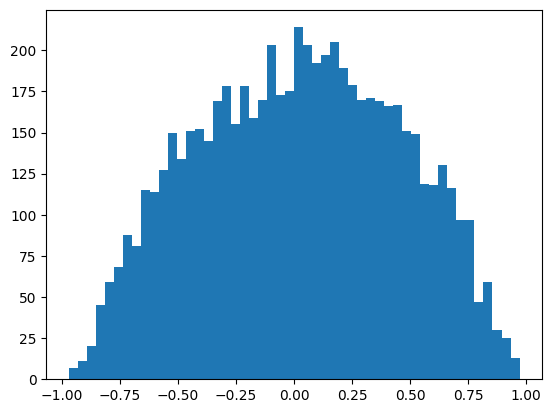

In [36]:
plt.hist(h.view(-1).tolist(), bins=50);  # сделаем из активаций вектор и превратим его в список, чтобы построить гистограмму значений
# видно, что тангенс стал менее радикальным

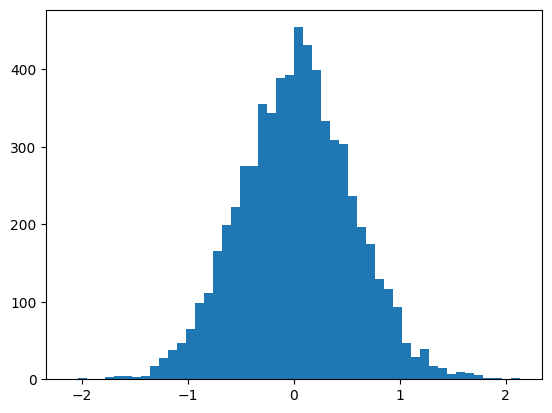

In [37]:
# почему так произошло? давайте посмотрим на то, что попадает на вход тангенсу
plt.hist(hpreact.view(-1).tolist(), bins=50);
# критичных значений стало в разы меньше

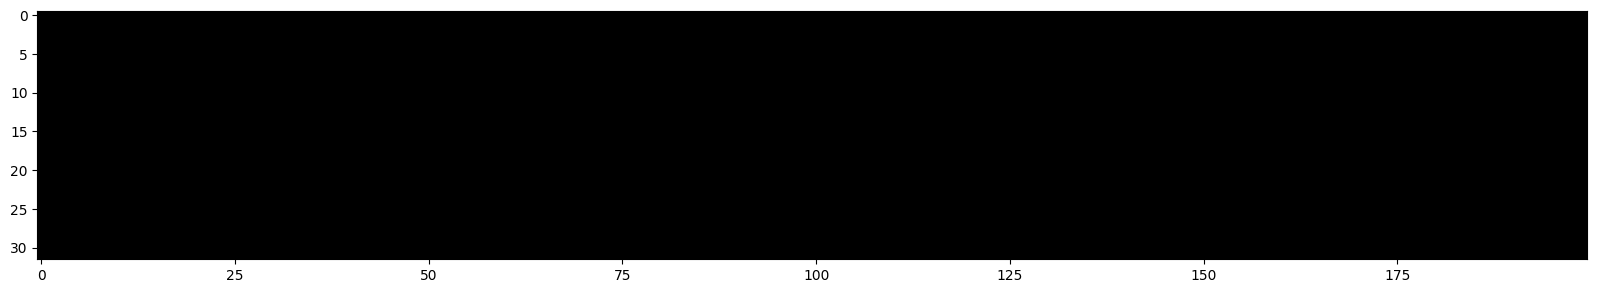

In [38]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');
# теперь ни одной белой колонки, значит в начале нет ситуации с мертвыми нейронами

In [39]:
# даже немного увелилим, не такую маленькую инициализацию

In [40]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g) * 0.2  # weights of 1 layer, чуть больше
b1 = torch.randn(n_hidden , generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size) , generator=g) * 0.01 
b2 = torch.randn(vocab_size , generator=g) * 0 

parameters = [C, W1, b1, W2, b2]  # all the parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

lr = 0.1
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # иногда делают обрезание learning rate после определенного количества итераций
    lr = 0.1 if i < 100000 else 0.01  
    
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    
    break

11897
      0/ 200000: 3.3088


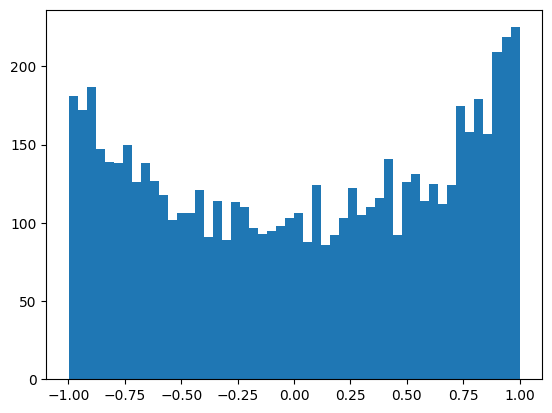

In [41]:
plt.hist(h.view(-1).tolist(), bins=50);  # сделаем из активаций вектор и превратим его в список, чтобы построить гистограмму значений
# вот хорошее распределение

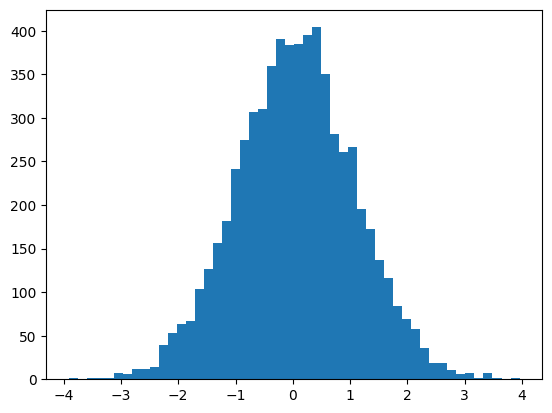

In [42]:
# почему так произошло? давайте посмотрим на то, что попадает на вход тангенсу
plt.hist(hpreact.view(-1).tolist(), bins=50);
# критичных значений стало в разы меньше

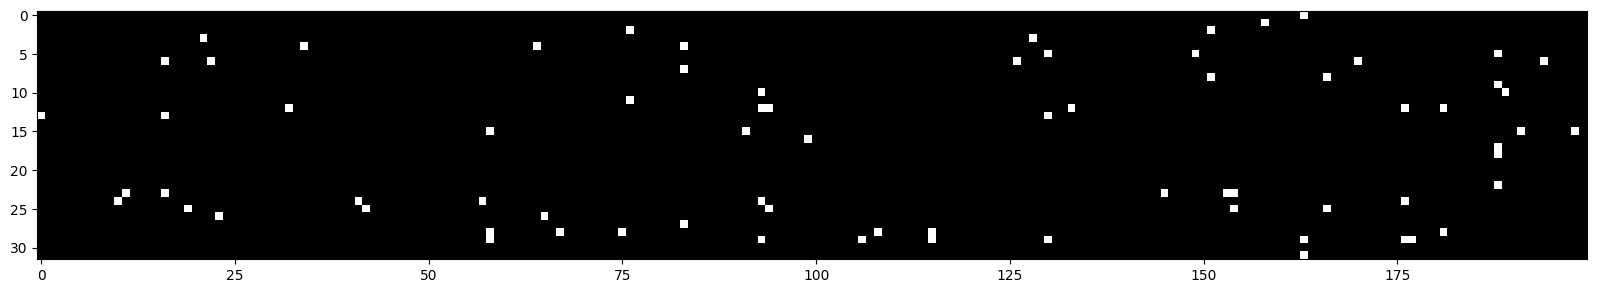

In [43]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');
# теперь ни одной белой колонки, значит в начале нет ситуации с мертвыми нейронами

In [44]:
# запустим обучение с такой инициализацией
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g) * 0.2
b1 = torch.randn(n_hidden , generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size) , generator=g) * 0.01 
b2 = torch.randn(vocab_size , generator=g) * 0 

parameters = [C, W1, b1, W2, b2]  # all the parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

lr = 0.1
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # иногда делают обрезание learning rate после определенного количества итераций
    lr = 0.1 if i < 100000 else 0.01  
    
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

11897
      0/ 200000: 3.3335
  10000/ 200000: 2.5202
  20000/ 200000: 2.2293
  30000/ 200000: 2.1707
  40000/ 200000: 2.0695
  50000/ 200000: 1.7805
  60000/ 200000: 1.6909
  70000/ 200000: 1.8769
  80000/ 200000: 2.2037
  90000/ 200000: 2.6178
 100000/ 200000: 2.0740
 110000/ 200000: 2.1405
 120000/ 200000: 2.1095
 130000/ 200000: 1.6328
 140000/ 200000: 2.0231
 150000/ 200000: 2.4113
 160000/ 200000: 1.8797
 170000/ 200000: 2.0640
 180000/ 200000: 2.3198
 190000/ 200000: 1.9240


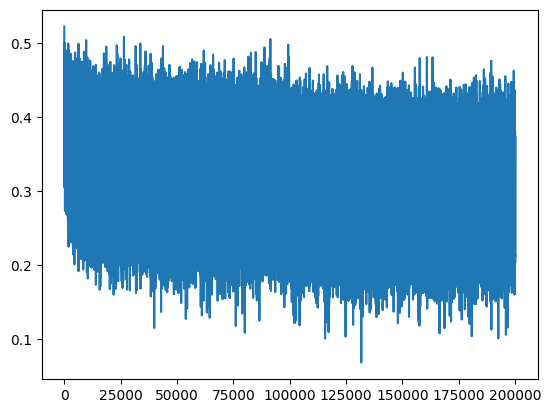

In [45]:
plt.plot(lossi);

In [46]:
# в итоге лосс даже стал еще лучше
split_loss('train')
split_loss('val')

train 2.0380921363830566
val 2.1037063598632812


In [47]:
# тем не менее, как вывод - нейросеть в примере - достаточно простая, и несмотря на плохую инициализацию она все равно учится
# инициализация просто увеличивает качество немного
# то есть ситуация простительна для такой сети, но чем больше слоев будет в сети - тем менее простительно будет делать плохую инициализацию
# нейросеть просто не будет учиться

# Выбор инициализации

In [48]:
# Мы получили неплохие результаты, домножив веса в инициализации на 0.01, 0.2 и другие, но что это за волшебные цифры?
# Как инициализовать веса в большой сети?

tensor(-0.0065) tensor(1.0014)
tensor(0.0027) tensor(3.0889)


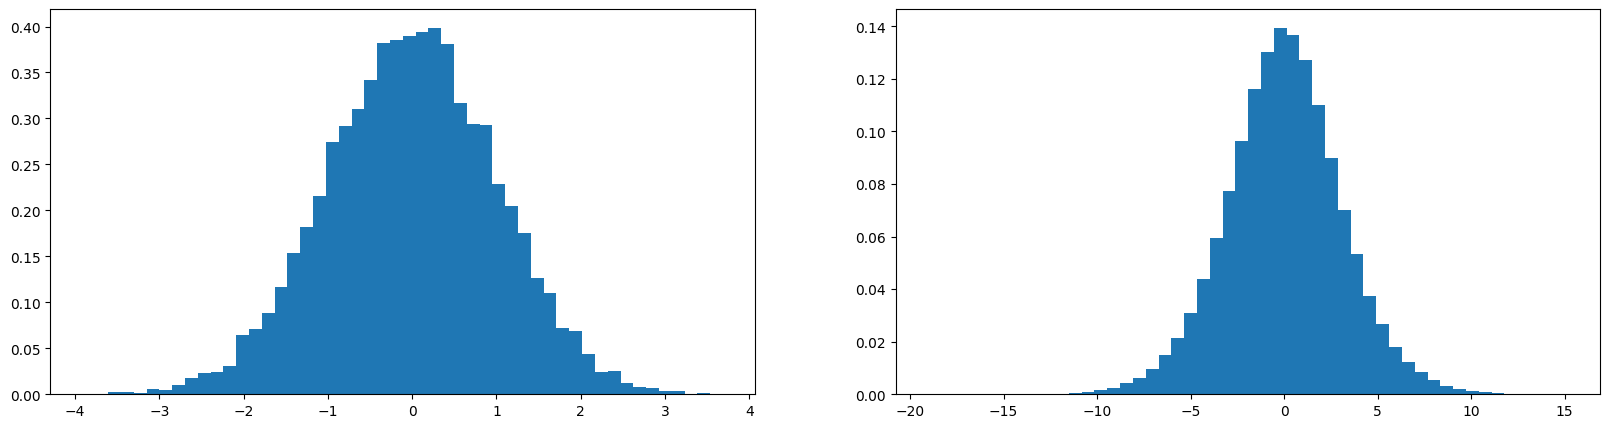

In [49]:
x = torch.randn(1000, 10)  # возьмем нормально распределенные входы
w = torch.randn(10, 200)  # нормально распределенные веса
y = x @ w  # перемножим
print(x.mean(), x.std())  # посмотрим на среднее значение
print(y.mean(), y.std())  # посмотрим на стандартное отклонение
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# распределение после слоя стало шире, стандартное отклонение стало в 3 раза больше, но мы не хотим, чтобы так было
# а то от слоя к слою будет взрыв значений
# вопрос: на какое число надо умножить инициализацию весов, чтобы стандартное отклонение оставалось 1?

tensor(0.0188) tensor(0.9996)
tensor(-0.0007) tensor(1.0050)


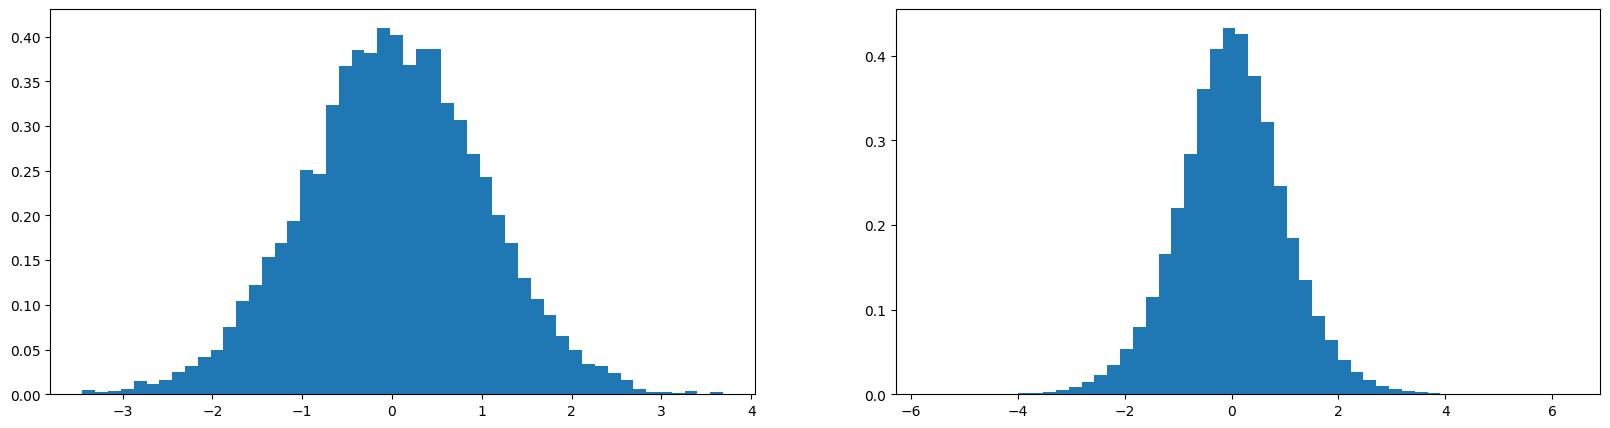

In [50]:
# https://arxiv.org/abs/1502.01852
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5  # нормально распределенные веса, разделим на корень из числа входов
y = x @ w  # перемножим
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [51]:
# https://pytorch.org/docs/stable/nn.init.html
# на практике, помимо инициализации помогают куча других методов: Residual connections, batchnorm, layernorm, ADAM и другие
# при инициализации не будет лишним позаботиться о весах и хотябы разделить их на корень из числа входов

In [52]:
# используем инициализацию из ссылок выше, учтем что у нас тангенс
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g) * (5/3)/((n_embd*block_size)**0.5) #* 0.2  # 5/3 - gain для tanh см ссылку из ячейки выше
b1 = torch.randn(n_hidden , generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size) , generator=g) * 0.01 
b2 = torch.randn(vocab_size , generator=g) * 0 

parameters = [C, W1, b1, W2, b2]  # all the parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

lr = 0.1
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # иногда делают обрезание learning rate после определенного количества итераций
    lr = 0.1 if i < 100000 else 0.01  
    
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

11897
      0/ 200000: 3.3255
  10000/ 200000: 2.1242
  20000/ 200000: 2.1004
  30000/ 200000: 2.0031
  40000/ 200000: 2.2564
  50000/ 200000: 2.7388
  60000/ 200000: 1.9283
  70000/ 200000: 1.8722
  80000/ 200000: 1.9205
  90000/ 200000: 2.4896
 100000/ 200000: 2.5700
 110000/ 200000: 1.9802
 120000/ 200000: 2.2910
 130000/ 200000: 1.8223
 140000/ 200000: 1.8009
 150000/ 200000: 2.3816
 160000/ 200000: 2.2188
 170000/ 200000: 2.1571
 180000/ 200000: 1.8296
 190000/ 200000: 2.3101


In [53]:
# пришли примерно к такому же лоссу, но не выдумывая волшебные числа для инициализации
split_loss('train')
split_loss('val')

train 2.038095235824585
val 2.1075761318206787


# BatchNorm

In [54]:
# мы хотим чтобы промежуточные выходы были нормально распределены, со средним 0 и отклонением 1, для этого занимались сложной инициализацией
# но что если можно просто взять и сделать их нормальными?

In [55]:
hpreact.shape, hpreact.mean(0, keepdim=True).shape, hpreact.std(0, keepdim=True).shape

(torch.Size([32, 200]), torch.Size([1, 200]), torch.Size([1, 200]))

In [56]:
# попробуем просто нормализовать значения перед тангенсом
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g) * (5/3)/((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden , generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size) , generator=g) * 0.01 
b2 = torch.randn(vocab_size , generator=g) * 0 

parameters = [C, W1, b1, W2, b2]  # all the parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

lr = 0.1
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)  # нормализуем
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # иногда делают обрезание learning rate после определенного количества итераций
    lr = 0.1 if i < 100000 else 0.01  
    
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

11897
      0/ 200000: 3.3273
  10000/ 200000: 2.2889
  20000/ 200000: 2.6015
  30000/ 200000: 2.3932
  40000/ 200000: 2.1592
  50000/ 200000: 1.9358
  60000/ 200000: 2.1084
  70000/ 200000: 2.4023
  80000/ 200000: 2.2590
  90000/ 200000: 2.2559
 100000/ 200000: 2.1917
 110000/ 200000: 2.4433
 120000/ 200000: 2.6196
 130000/ 200000: 2.2861
 140000/ 200000: 1.6777
 150000/ 200000: 2.2576
 160000/ 200000: 2.0960
 170000/ 200000: 2.2089
 180000/ 200000: 1.9860
 190000/ 200000: 1.7649


In [57]:
# сделаем как в статье про batchnorm и добавим еще параметры для нормировки
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g) * (5/3)/((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden , generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size) , generator=g) * 0.01 
b2 = torch.randn(vocab_size , generator=g) * 0 

bngain = torch.ones((1, n_hidden))  # масштаб batchnorm
bnbias = torch.zeros((1, n_hidden))  # смещение batchnorm

parameters = [C, W1, b1, W2, b2, bngain, bnbias]  # all the parameters, сюда их тоже добавим
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

lr = 0.1
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # иногда делают обрезание learning rate после определенного количества итераций
    lr = 0.1 if i < 100000 else 0.01  
    
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

12297
      0/ 200000: 3.3211
  10000/ 200000: 2.5232
  20000/ 200000: 2.0399
  30000/ 200000: 2.1333
  40000/ 200000: 2.0191
  50000/ 200000: 2.3198
  60000/ 200000: 2.2925
  70000/ 200000: 2.3635
  80000/ 200000: 2.3939
  90000/ 200000: 2.2314
 100000/ 200000: 2.0654
 110000/ 200000: 1.8842
 120000/ 200000: 1.8984
 130000/ 200000: 2.1814
 140000/ 200000: 2.1658
 150000/ 200000: 1.8967
 160000/ 200000: 2.2247
 170000/ 200000: 2.2922
 180000/ 200000: 2.2355
 190000/ 200000: 2.0060


In [58]:
# надо и поменять подсчет метрик
@torch.no_grad()  # декоратор отключает отслеживание градиентов
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.068838596343994
val 2.107182025909424


In [59]:
# мы не получили большой прибавки от batchnorm, потому что сеть маленькая
# к тому же мы уже вручную подобрали инициализацию
# но batchnorm позволяет в общем этого не делать и стабилизирует обучение

In [60]:
# но если задуматься, то происходит что-то странное
# данные на вход тангенса теперь поступают батчами, а значит выход конкретного значения теперь зависит еще и от значений в батче
# который мы формируем случайно

# но каким-то чудом получается, что это идет только на пользу обучению сети и выступает в роли регуляризатора
# так как в зависимости от того с кем в батче попалось сейчас это значение - зависит и ответ, некая аугментация получается и нейросети труднее
# переобучиться и запомнить значение
# но иногда это приводит к странным вещам, и поэтому люди пытаются уйти от его использования в пользу layernorm, groupnorm, instancenorm

In [61]:
# есть еще один момент, добавив нормализацию по батчу мы теперь каким образом должны скормить сети один сэмпл данных?
# теперь на вход она ожидает батчи
# статья предложила выход

In [62]:
# замерим статистики по всем данным
with torch.no_grad():

    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    # замерим среднее значение и стандартное отклонение 1 раз
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [63]:
# теперь мы можем пройтись и по 1 строке данных
@torch.no_grad()  # декоратор отключает отслеживание градиентов
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.068838596343994
val 2.1071338653564453


In [64]:
# но никто не хочет после обучения считать статистики по всем данным
# мы просто будем во время обучения запоминать статистики в виде скользящего среднего
# сделаем как в статье про batchnorm и добавим еще параметры для нормировки
# попробуем просто нормализовать значения перед тангенсом
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g) * (5/3)/((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden , generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size) , generator=g) * 0.01 
b2 = torch.randn(vocab_size , generator=g) * 0 

bngain = torch.ones((1, n_hidden))  # масштаб batchnorm
bnbias = torch.zeros((1, n_hidden))  # смещение batchnorm
bnmean_running = torch.zeros((1, n_hidden))  # запоминаем значения
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]  # all the parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

lr = 0.1
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    
    bnmeani = hpreact.mean(0, keepdim=True)  # запишем среднее на i итерации
    bnstdi = hpreact.std(0, keepdim=True)  # запишем стандартное отклонение на i итерации
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    # сохраним скользящие значения
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # иногда делают обрезание learning rate после определенного количества итераций
    lr = 0.1 if i < 100000 else 0.01  
    
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

12297
      0/ 200000: 3.3068
  10000/ 200000: 2.2005
  20000/ 200000: 2.2953
  30000/ 200000: 2.2758
  40000/ 200000: 2.4331
  50000/ 200000: 2.2866
  60000/ 200000: 2.0627
  70000/ 200000: 2.4996
  80000/ 200000: 2.2436
  90000/ 200000: 2.2165
 100000/ 200000: 1.9935
 110000/ 200000: 2.0290
 120000/ 200000: 2.0686
 130000/ 200000: 1.9170
 140000/ 200000: 1.8432
 150000/ 200000: 2.3237
 160000/ 200000: 2.1857
 170000/ 200000: 2.6847
 180000/ 200000: 1.8411
 190000/ 200000: 1.9681


In [65]:
# теперь мы просто сохраняли бегущие значения статистик и ожидаем, что они будут достаточно близки к средним значениям по всем данным
bnmean_running

tensor([[-2.5591,  0.1837, -2.5294,  0.5808,  1.0508,  0.7052,  2.5851, -0.4030,
          1.2795,  0.8841, -1.8091, -2.4534, -0.3462, -0.3974,  0.1839,  0.1032,
          0.4453, -2.3841, -0.4457,  1.7722, -0.4903,  0.0301,  0.7098,  0.5096,
          0.7534, -0.4689,  1.4275,  0.1271,  0.1735,  2.0317, -0.2400, -1.4478,
          1.4062,  0.3603,  0.0803, -0.2197, -0.3203,  0.0164, -0.2247,  0.7219,
         -0.2018, -1.0687, -0.7614,  0.3231,  0.8492,  1.4804,  1.5663, -0.3306,
          2.5677,  1.2280,  1.9799, -0.2896,  1.8970,  1.8874,  0.8914, -1.9576,
         -0.2328,  0.1118,  1.2374, -1.1236, -0.9568,  0.8675, -0.0450,  0.2115,
          1.4890,  1.8834, -0.7360,  1.6095, -0.2351, -0.3152,  0.1648,  0.2589,
          0.1581, -1.1752, -2.1474,  0.4563,  1.2460, -1.0208,  0.5481,  0.4102,
          0.0567,  1.4441,  1.3465,  1.0112,  1.2207, -0.7311, -0.4861,  0.1959,
          2.4340, -0.5798, -1.9908,  1.4054, -0.3860, -1.2642, -1.1552,  0.6841,
          0.3029, -1.4430,  

In [66]:
bnmean

tensor([[-1.9819, -0.0340, -0.9082,  1.5724,  0.7569,  1.0613,  3.3825, -0.8043,
          1.3066,  1.7304, -1.1451, -2.5756, -0.8053,  0.4412, -0.1030, -0.2679,
          0.8535, -2.1427, -0.4681,  0.9868, -0.0077, -0.0406, -0.7215,  0.1413,
          1.5130, -0.0086,  1.0645, -0.2068,  0.8587,  1.3112, -0.1616, -1.2471,
          0.8482,  0.7946,  0.0745, -0.7264,  0.2373,  0.4362, -0.2291,  0.3988,
         -0.0299, -1.3959, -0.5022,  0.0797,  0.5836,  0.9678,  1.5094, -1.6957,
          2.6821,  1.4857,  0.6671,  0.4649,  1.5043,  1.0209,  0.4097, -2.5513,
          0.1335,  0.1033,  1.4282, -0.6730, -0.2444,  0.8021,  0.9081,  0.9496,
          1.6557,  2.0209, -0.5012,  1.6128, -0.8548,  0.4389, -0.9915,  0.4234,
          0.6382, -2.6424, -3.0509, -0.4026,  1.4353, -0.7358, -0.1196,  0.2928,
          0.4065,  1.6140,  1.4924,  0.7622,  0.1836, -0.3909,  0.0334, -0.0406,
          2.5406, -0.8251, -0.6509,  0.4511, -1.0609, -1.0457, -1.3524,  0.5846,
          0.4081, -1.4015,  

In [67]:
# теперь мы можем использовать бегущие значения
@torch.no_grad()  # декоратор отключает отслеживание градиентов
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    hpreact = embcat @ W1 + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.068274974822998
val 2.1100828647613525


In [70]:
# есть еще пара моментов: в знаменателе в статье добавляют маленькое число - оно нужно для того, чтобы избежать деления на 0
# второй момент - нам теперь не нужно смещение b1, так как мы добавляем смещение при нормализации, по сути тратим параметры впустую
# если посмотреть на градиент b1 он будет 0 потому что она все равно вычетается

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g) * (5/3)/((n_embd*block_size)**0.5)
# b1 = torch.randn(n_hidden , generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size) , generator=g) * 0.01 
b2 = torch.randn(vocab_size , generator=g) * 0 

bngain = torch.ones((1, n_hidden))  # масштаб batchnorm
bnbias = torch.zeros((1, n_hidden))  # смещение batchnorm
bnmean_running = torch.zeros((1, n_hidden))  # запоминаем значения
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]  # all the parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

lr = 0.1
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]  # [batch_size, block_size, embd]
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size]
    # --------------------Linear Layer---------------------
    hpreact = embcat @ W1# + b1
    # --------------------BatchNorm Layer---------------------
    bnmeani = hpreact.mean(0, keepdim=True)  # запишем среднее на i итерации
    bnstdi = hpreact.std(0, keepdim=True)  # запишем стандартное отклонение на i итерации
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    # сохраним скользящие значения
    with torch.no_grad():
        bnmean_running = 0.99 * bnmean_running + 0.01 * bnmeani
        bnstd_running = 0.99 * bnstd_running + 0.01 * bnstdi
    # --------------------Nonliearity---------------------
    h = torch.tanh(hpreact)  # [batch_size, hidden_size]
    logits = h @ W2 + b2  # [batch_size, vocab_size]
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # иногда делают обрезание learning rate после определенного количества итераций
    lr = 0.1 if i < 100000 else 0.01  
    
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

12097
      0/ 200000: 3.3177
  10000/ 200000: 2.3127
  20000/ 200000: 2.4311
  30000/ 200000: 2.5011
  40000/ 200000: 1.9770
  50000/ 200000: 1.8496
  60000/ 200000: 2.1094
  70000/ 200000: 2.3115
  80000/ 200000: 1.9933
  90000/ 200000: 1.9720
 100000/ 200000: 2.4934
 110000/ 200000: 2.0782
 120000/ 200000: 1.9607
 130000/ 200000: 2.1321
 140000/ 200000: 2.0465
 150000/ 200000: 1.9119
 160000/ 200000: 2.0384
 170000/ 200000: 2.1836
 180000/ 200000: 1.7184
 190000/ 200000: 1.9919


In [72]:
split_loss('train')
split_loss('val')

train 2.0652365684509277
val 2.1066200733184814


In [71]:
# небольшая заметка по тому, насколько маленький брать momentum при подсчете скользящих средних
# если батч достаточно большой, то можно взять его побольше
# но если батч маленький, то средние по батчу могут сильно скакать и при большом momentum могут не сойтись к истинным значениям средних

# Основные заметки по итогу

- Важно смотреть на распределения выходов нейронной сети, особенно последнего слоя на предмет черезчур уверенных предсказаний,
как с примером для уменьшения начального лосса, ведь если избавиться от резкого наклона лосса в начале обучения - можно обучиться лучше

- Смотреть на активации, мы не хотим чтобы они выпадали сразу в критичные значения -1 и 1 и попросту не обучались, через нейросеть должны проходить
примерно Гауссовские распределения значений

- Для максимального контроля "Гауссовости" выходов конечно используют инициализацию весов, но для больших сетей с разнообразными слоями
очень трудно настроить инициализацию весов для нормальности выходов сети

- Здесь на помощь приходят слои нормализации, например, батч нормализация.
Мы просто нормализуем слои считая средние.
Но как сделать инференс по такому слою?

- Очень просто: мы считаем средние по всем данным и используем их для инференса, но никто не хочет этого делать, поэтому используют скользящие средние

- Но на самом деле этот слой никто не любит из-за потенциальных багов в нем. Мы считаем статистики по маленьким наборам данных и это приводит иногда непонятно к чему, так что по возможности стоит избегать этот слой и использовать альтернативные слои нормализации, которые очень и очень нужны!

# Pytorch-ifying the code

In [6]:
# соберем все в более удобный вид модулей и попробуем обучить более глубокую сеть
# используем self.out для того, чтобы потом смотреть на выходы слоев

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True  # дополнительный флаг, который говорит нам, находимся ли мы сейчас в режиме обучения
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)  # среднее по батчу во время обучения
            xvar = x.var(0, keepdim=True, unbiased=True)  # дисперсия по батчу во время обучения
        else:
            xmean = self.running_mean  # среднее, которое используем на инференсе
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # нормализуем вход
        self.out = self.gamma * xhat + self.beta
        # обновим буфферы
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [86]:
n_embd = 10  # размер эмбеддинга
n_hidden = 100  # число нейронов в скрытом слое сети
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # последний слой сделать менее уверенным
    layers[-1].weight *= 0.1
    # ко всем остальным слоя применить нормализацию
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [87]:
# такая же оптимизация как и раньше
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    emb = C[Xb]  # получаем эмбеддинги букв
    x = emb.view(emb.shape[0], -1)  # соединяем векторы букв
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # считаем лосс

    # backward pass
    for layer in layers:
        # по умолчанию торч считает градиенты только для тензоров-листов, которым выход не является (только веса и вход)
        layer.out.retain_grad()  # позволяет считать градиент по выходу, нужно для того, чтобы посмотреть

    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break  # чтобы посмотреть

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


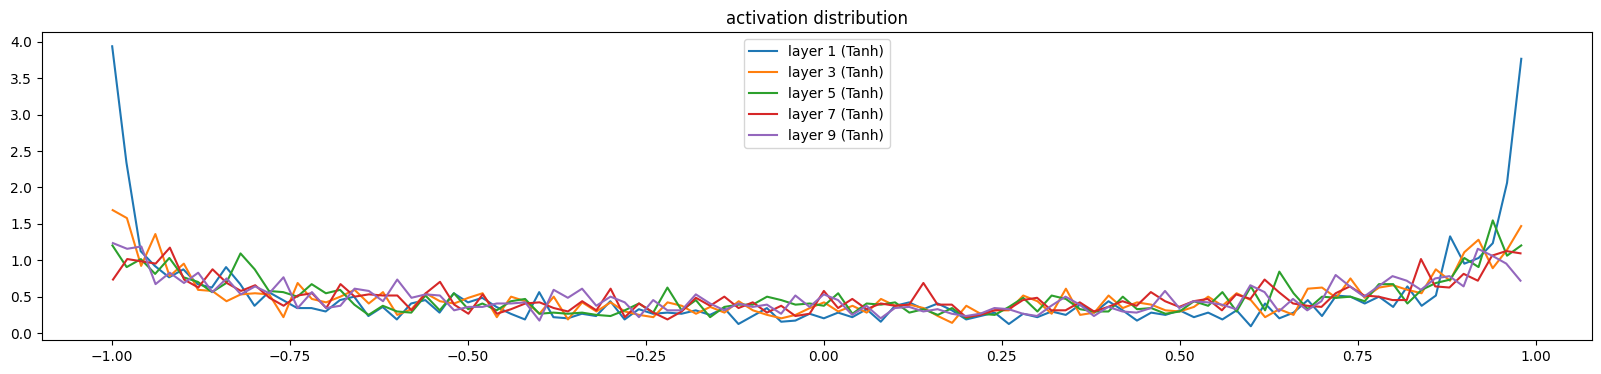

In [89]:
# изобразим для каждого тангенса распределение выходов
# посмотрим на среднее значение, стандартное отклонение, % значений превыщающих 0.97 по модулю (значит мы в концах распределения)
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

In [90]:
# первый слой очень сильно сжат по значениям -1 и 1, но дальше картинка стабилизируется
# и причина по которой они стабилизируются - это gain 5/3, попробуем убрать его и посмотрим что будет

In [107]:
n_embd = 10  # размер эмбеддинга
n_hidden = 100  # число нейронов в скрытом слое сети
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1
    # ко всем остальным слоя применить нормализацию
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1  # !!!!!!! НЕ ИСПОЛЬЗУЕМ GAIN!!!!!!!

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# такая же оптимизация как и раньше
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    emb = C[Xb]  # получаем эмбеддинги букв
    x = emb.view(emb.shape[0], -1)  # соединяем векторы букв
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # считаем лосс

    # backward pass
    for layer in layers:
        # по умолчанию торч считает градиенты только для тензоров-листов, которым выход не является (только веса и вход)
        layer.out.retain_grad()  # позволяет считать градиент по выходу, нужно для того, чтобы посмотреть

    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break  # чтобы посмотреть

46497
      0/ 200000: 3.2988


layer 1 (      Tanh): mean -0.02, std 0.62, saturated: 3.50%
layer 3 (      Tanh): mean -0.00, std 0.48, saturated: 0.03%
layer 5 (      Tanh): mean +0.00, std 0.41, saturated: 0.06%
layer 7 (      Tanh): mean +0.00, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.02, std 0.32, saturated: 0.00%


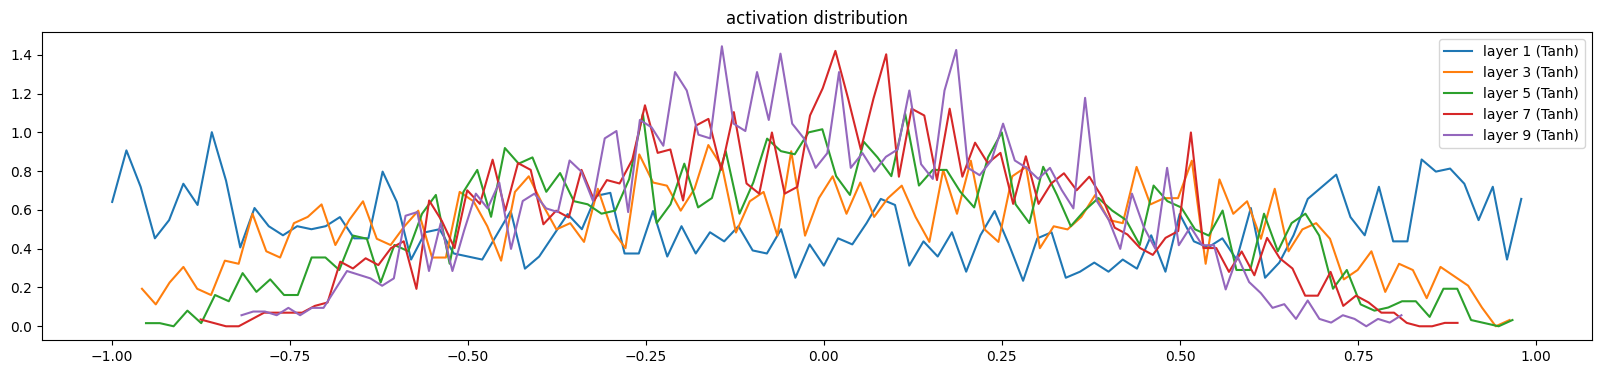

In [108]:
# изобразим для каждого тангенса распределение выходов
# посмотрим на среднее значение, стандартное отклонение, % значений превыщающих 0.97 по модулю (значит мы в концах распределения)
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

In [102]:
# видно, что в таком случае стандартное отклонение становится все меньше и меньше и сатурация уменьшается до нуля
# первый слой конечно достаточно хороший, но последующие слои сжимаются в ноль, хоть и медленно

# проиходит это вот почему: представим что у нас есть стопка только линейных слоев, и, если мы вспомним - инициализация весов с 
# делением на корень из числа входов стремится удержать стандартное отклонение в районе 1
# но, если мы добавим слой тангенса (это сжимающая функция), то мы будет сжимать это распределение каждый раз по чуть-чуть
# и поэтому необходим небольшой gain, чтобы бороться с этим сжатием и не получить в итоге слой из нулей

# можно попробовать поставить значения gain поменьше, например 0.5 или 0.3 и увидеть, как быстро мы из выхода слоя будем получать нули
# или наоборот поставить высокий gain - и увидеть большую сатурацию, поэтому 5/3 для тангенса - оптимально
# при нем стаблизируется и сатурация и стандартное отклонение

# The 5/3 gain in the tanh comes for the average value of tanh^2(x) where x is distributed as a Gaussian, i.e.
# integrate (tanh x)^2*exp(-x^2/2)/sqrt(2*pi) from -inf to inf ~= 0.39
# The square root of this value is how much the tanh squeezes the variance of the incoming variable: 0.39 ** .5 ~= 0.63 ~= 3/5 (hence 5/3 is just an approximation of the exact gain).
# We then multiply by the gain to keep the output variance 1.

In [109]:
# можно проделать все тоже самое с градиентами

In [110]:
n_embd = 10  # размер эмбеддинга
n_hidden = 100  # число нейронов в скрытом слое сети
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1
    # ко всем остальным слоя применить нормализацию
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# такая же оптимизация как и раньше
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    emb = C[Xb]  # получаем эмбеддинги букв
    x = emb.view(emb.shape[0], -1)  # соединяем векторы букв
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # считаем лосс

    # backward pass
    for layer in layers:
        # по умолчанию торч считает градиенты только для тензоров-листов, которым выход не является (только веса и вход)
        layer.out.retain_grad()  # позволяет считать градиент по выходу, нужно для того, чтобы посмотреть

    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break  # чтобы посмотреть

46497
      0/ 200000: 3.2962


layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


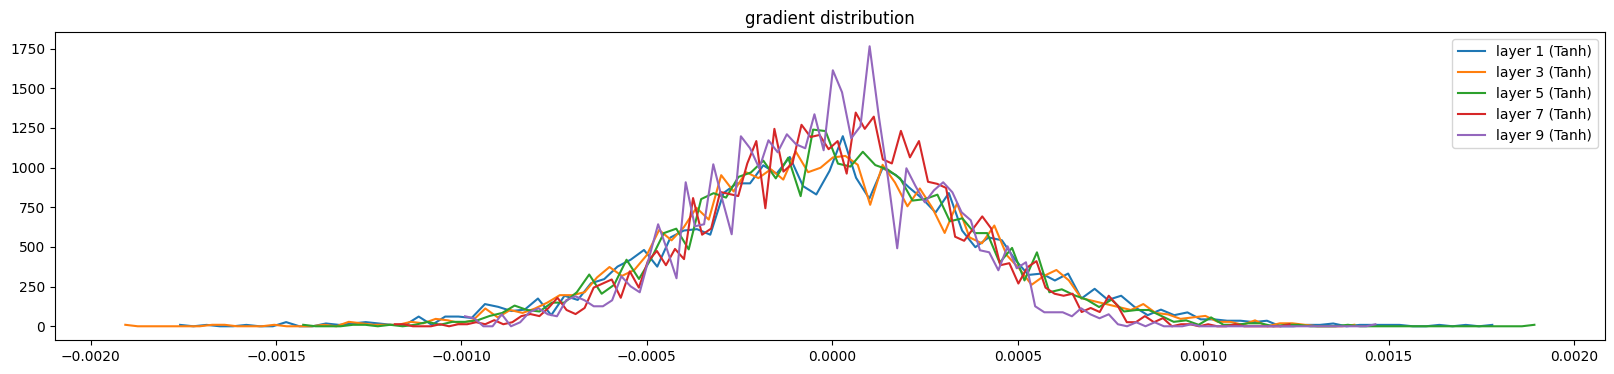

In [111]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');

In [112]:
# на что нам здесь интересно посмотреть - это то, что все градиенты в сэндвиче имеют примерно одинаковое распределение
# не сжимаются и не расжимаются

In [113]:
n_embd = 10  # размер эмбеддинга
n_hidden = 100  # число нейронов в скрытом слое сети
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # последний слой сделать менее уверенным
    layers[-1].weight *= 0.1
    # ко всем остальным слоя применить нормализацию
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.5  # !!!!!! УМЕНЬШИМ

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# такая же оптимизация как и раньше
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    emb = C[Xb]  # получаем эмбеддинги букв
    x = emb.view(emb.shape[0], -1)  # соединяем векторы букв
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # считаем лосс

    # backward pass
    for layer in layers:
        # по умолчанию торч считает градиенты только для тензоров-листов, которым выход не является (только веса и вход)
        layer.out.retain_grad()  # позволяет считать градиент по выходу, нужно для того, чтобы посмотреть

    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break  # чтобы посмотреть

46497
      0/ 200000: 3.2960


layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


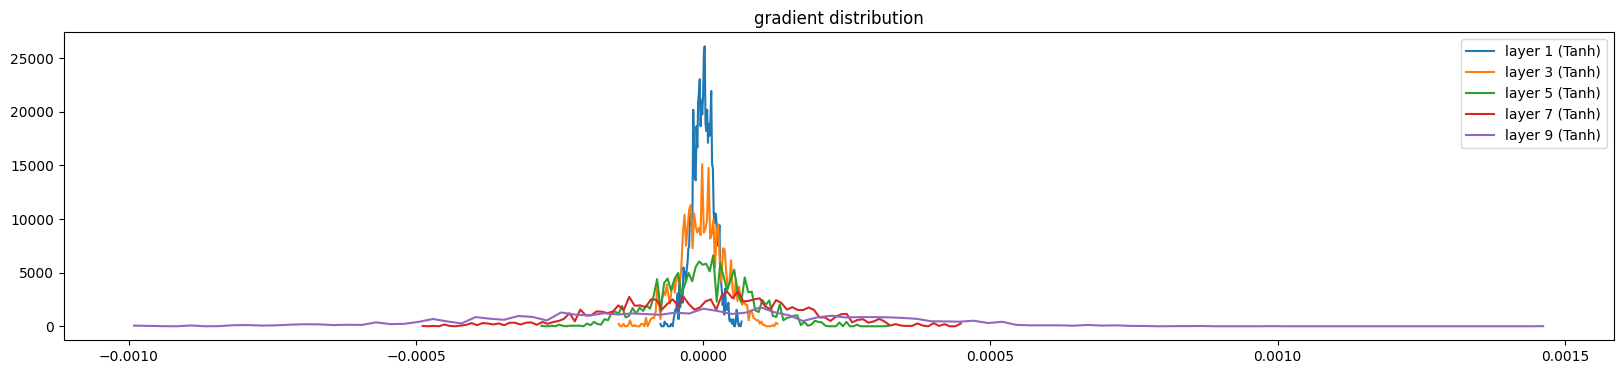

In [114]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');

In [115]:
# уменьшим gain мы видим что распределения градиентов поплыли - стали расширяться от 1 к 9 слою
# подобную ситуацию можно увидеть увеличив gain
# так что до тех пор, пока мы не ушли в сторону batchnorm - мы должны очень аккуратно подходить к инициализации

## Уберем активации

In [118]:
n_embd = 10  # размер эмбеддинга
n_hidden = 100  # число нейронов в скрытом слое сети
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden),# Tanh(),
    Linear(n_hidden, n_hidden),# Tanh(),
    Linear(n_hidden, n_hidden),# Tanh(),
    Linear(n_hidden, n_hidden),# Tanh(),
    Linear(n_hidden, n_hidden),# Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1
    # ко всем остальным слоя применить нормализацию
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3  # !!!!!! ОСТАВИМ БОЛЬШИМ ДЛЯ ЛИНЕЙНЫХ СЛОЕВ (КАК МЫ ПОМНИМ ДОЛЖНО БЫТЬ 1)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# такая же оптимизация как и раньше
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    emb = C[Xb]  # получаем эмбеддинги букв
    x = emb.view(emb.shape[0], -1)  # соединяем векторы букв
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # считаем лосс

    # backward pass
    for layer in layers:
        # по умолчанию торч считает градиенты только для тензоров-листов, которым выход не является (только веса и вход)
        layer.out.retain_grad()  # позволяет считать градиент по выходу, нужно для того, чтобы посмотреть

    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break  # чтобы посмотреть

46497
      0/ 200000: 4.0240


layer 0 (    Linear): mean -0.04, std 1.65, saturated: 55.12%
layer 1 (    Linear): mean -0.04, std 2.72, saturated: 71.78%
layer 2 (    Linear): mean -0.00, std 4.67, saturated: 81.31%
layer 3 (    Linear): mean +0.09, std 7.50, saturated: 91.19%
layer 4 (    Linear): mean -0.72, std 12.78, saturated: 93.69%


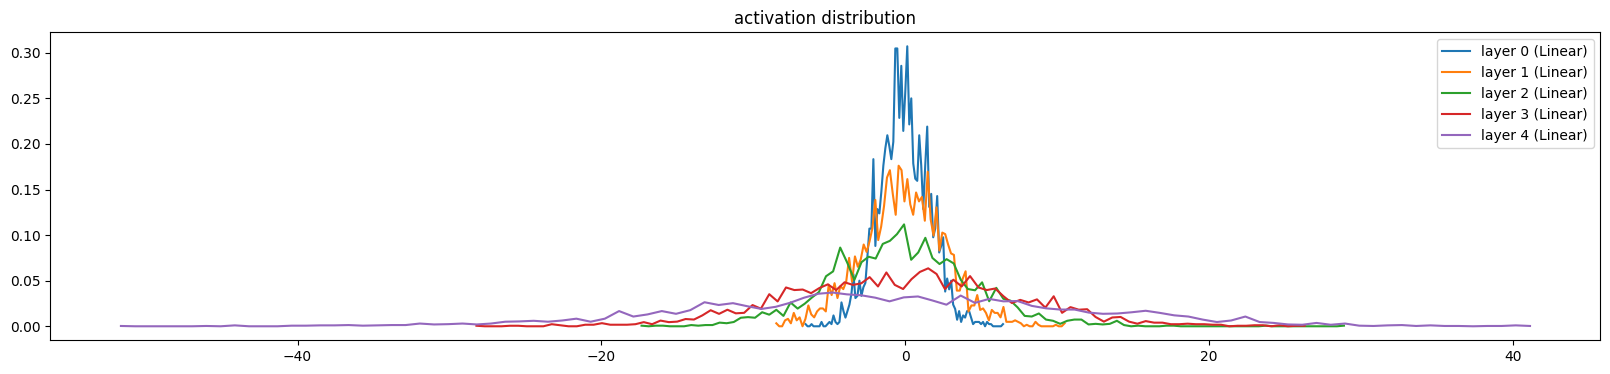

In [121]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

layer 0 (    Linear): mean +0.00, std 0.00, saturated: 0.00%
layer 1 (    Linear): mean -0.00, std 0.00, saturated: 0.00%
layer 2 (    Linear): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (    Linear): mean +0.00, std 0.00, saturated: 0.00%
layer 4 (    Linear): mean -0.00, std 0.00, saturated: 0.00%


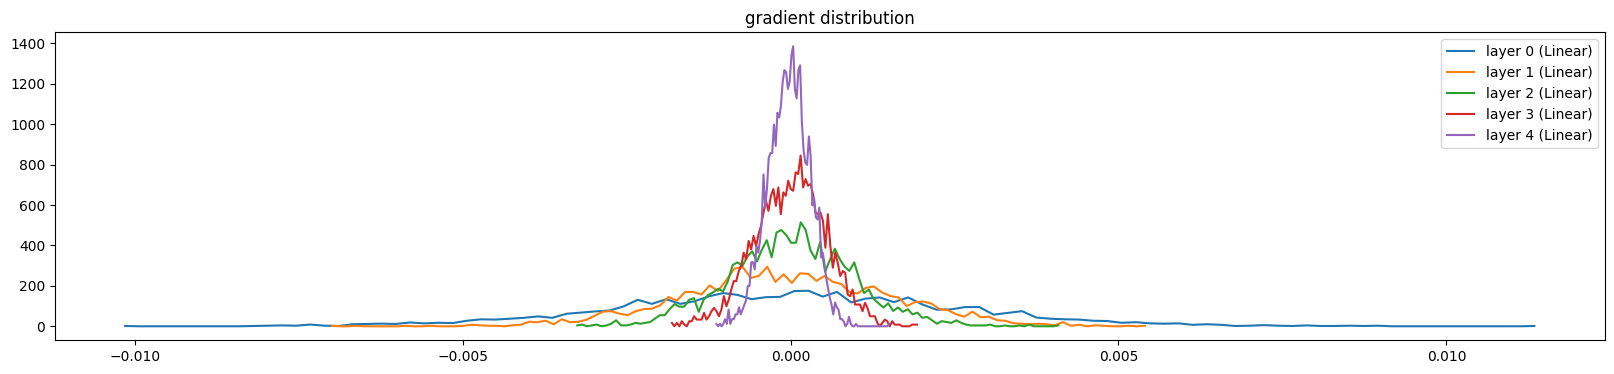

In [120]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');

In [124]:
# видно что стандартное отклонение выходов увеличивается от слоя к слою, как мы показывали в примерах выше
# для больших нейросетей это может быть проблемой

# если поставить маленький gain, то увидим противоположную картину сжатия и расширения, поэтому до батч нормализации была важна настройка инициализации

In [125]:
# для такой картины корректный gain=1, посмотрим как будет выглядит при нем

In [126]:
n_embd = 10  # размер эмбеддинга
n_hidden = 100  # число нейронов в скрытом слое сети
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden),# Tanh(),
    Linear(n_hidden, n_hidden),# Tanh(),
    Linear(n_hidden, n_hidden),# Tanh(),
    Linear(n_hidden, n_hidden),# Tanh(),
    Linear(n_hidden, n_hidden),# Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1
    # ко всем остальным слоя применить нормализацию
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1  # !!!!!! 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# такая же оптимизация как и раньше
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    emb = C[Xb]  # получаем эмбеддинги букв
    x = emb.view(emb.shape[0], -1)  # соединяем векторы букв
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # считаем лосс

    # backward pass
    for layer in layers:
        # по умолчанию торч считает градиенты только для тензоров-листов, которым выход не является (только веса и вход)
        layer.out.retain_grad()  # позволяет считать градиент по выходу, нужно для того, чтобы посмотреть

    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break  # чтобы посмотреть

46497
      0/ 200000: 3.3019


layer 0 (    Linear): mean -0.02, std 0.99, saturated: 32.16%
layer 1 (    Linear): mean -0.01, std 0.98, saturated: 31.12%
layer 2 (    Linear): mean -0.00, std 1.01, saturated: 31.16%
layer 3 (    Linear): mean +0.01, std 0.97, saturated: 31.66%
layer 4 (    Linear): mean -0.06, std 0.99, saturated: 32.47%


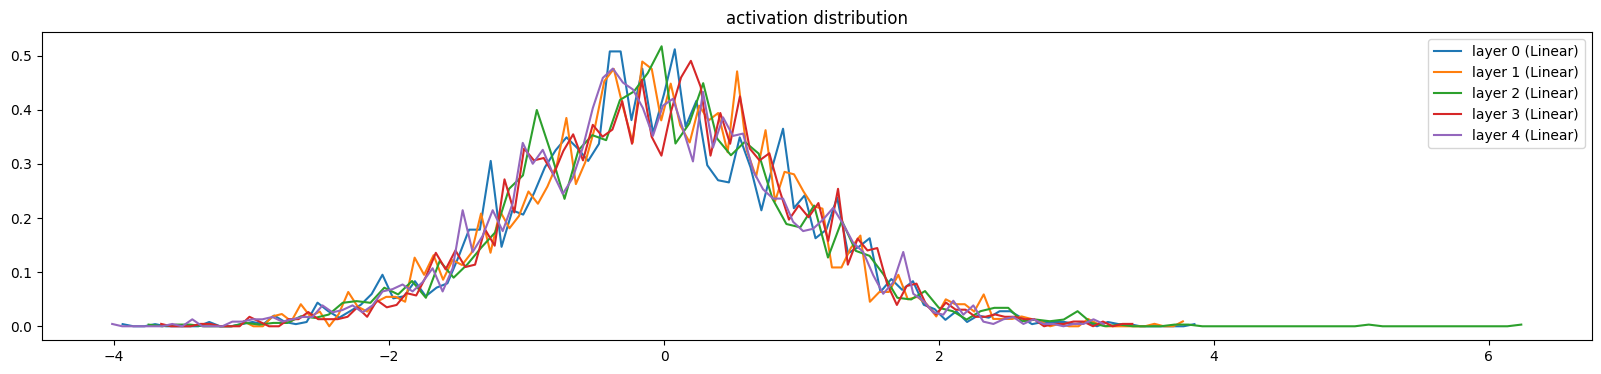

In [127]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

layer 0 (    Linear): mean +0.00, std 0.00, saturated: 0.00%
layer 1 (    Linear): mean -0.00, std 0.00, saturated: 0.00%
layer 2 (    Linear): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (    Linear): mean +0.00, std 0.00, saturated: 0.00%
layer 4 (    Linear): mean -0.00, std 0.00, saturated: 0.00%


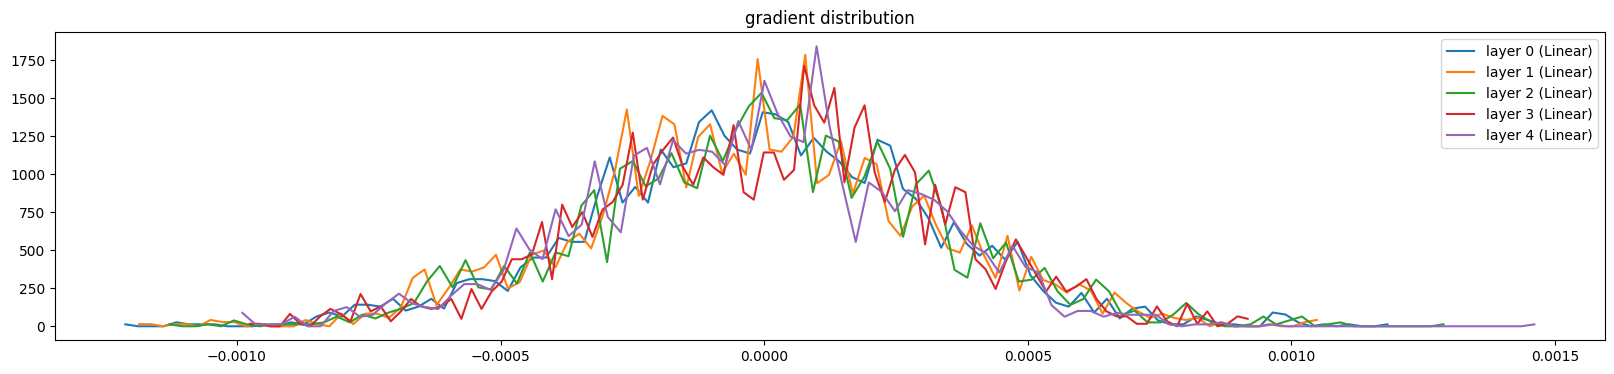

In [128]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');

In [129]:
# до появления ADAM Residual, BatchNorm, обучить нейросеть большой глубины было почти нереально, потому что подбирать
# инициализации - дело тонкое

In [130]:
# но зачем нам вообще нужны активации? и беспокоиться о gain?
# дело в том, что независимо от того сколько линейных слоев наложить друг на друга, выход будет линейным

## Параметры

In [151]:
# вернем все как было
n_embd = 10  # размер эмбеддинга
n_hidden = 100  # число нейронов в скрытом слое сети
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1
    # ко всем остальным слоя применить нормализацию
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# такая же оптимизация как и раньше
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    emb = C[Xb]  # получаем эмбеддинги букв
    x = emb.view(emb.shape[0], -1)  # соединяем векторы букв
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # считаем лосс

    # backward pass
    for layer in layers:
        # по умолчанию торч считает градиенты только для тензоров-листов, которым выход не является (только веса и вход)
        layer.out.retain_grad()  # позволяет считать градиент по выходу, нужно для того, чтобы посмотреть

    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break  # чтобы посмотреть

46497
      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


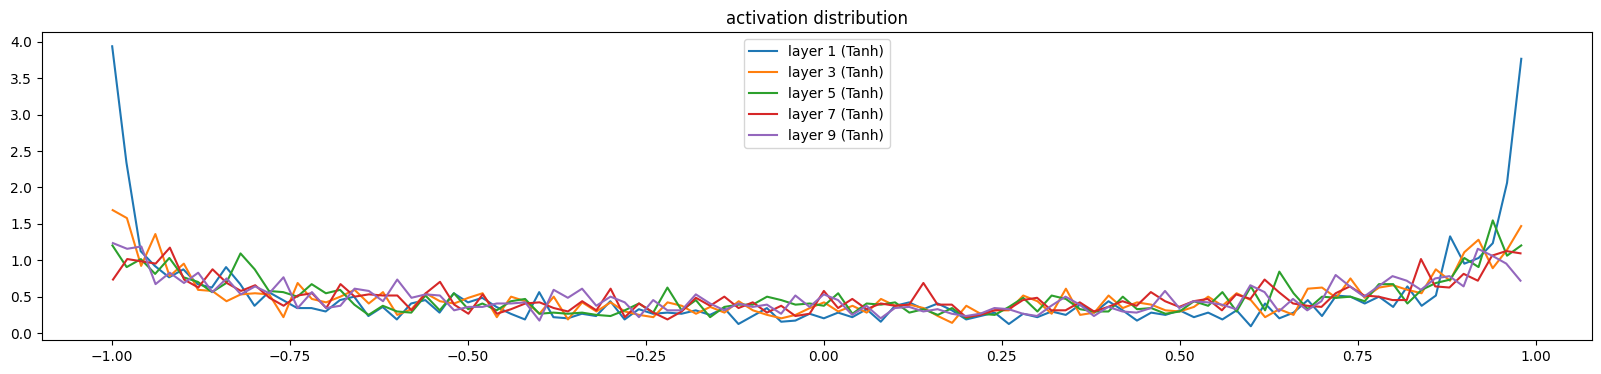

In [152]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


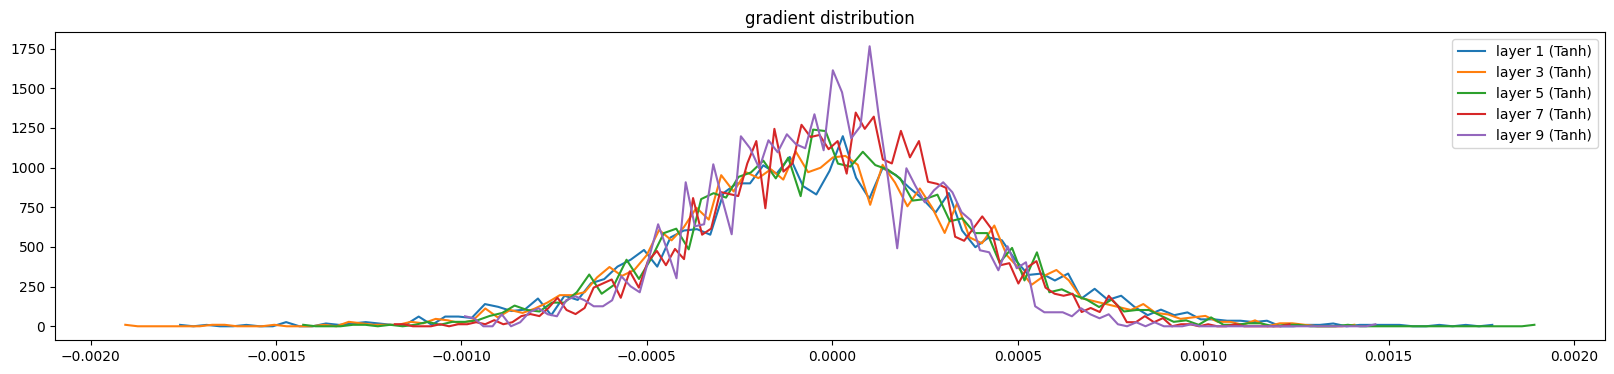

In [153]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean -0.000031 | std 1.365078e-03 | grad:data ratio 1.364090e-03
weight  (30, 100) | mean -0.000049 | std 1.207430e-03 | grad:data ratio 3.871660e-03
weight (100, 100) | mean +0.000016 | std 1.096730e-03 | grad:data ratio 6.601988e-03
weight (100, 100) | mean -0.000010 | std 9.893572e-04 | grad:data ratio 5.893091e-03
weight (100, 100) | mean -0.000011 | std 8.623432e-04 | grad:data ratio 5.158124e-03
weight (100, 100) | mean -0.000004 | std 7.388576e-04 | grad:data ratio 4.415211e-03
weight  (100, 27) | mean -0.000000 | std 2.364824e-02 | grad:data ratio 2.328203e+00


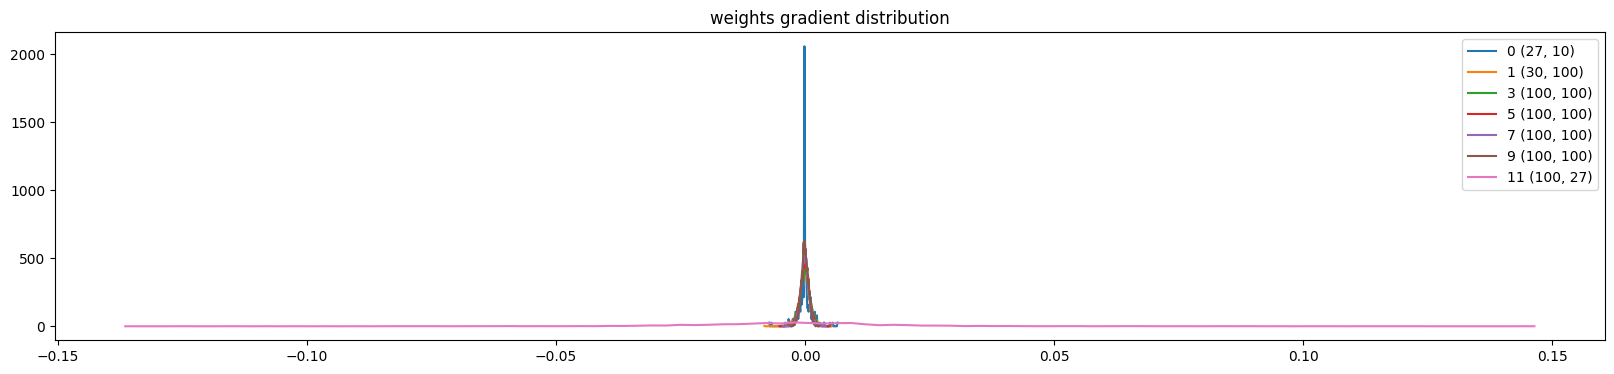

In [154]:
# визуализируем значения градиентов параметров
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

In [155]:
# интересно посмотреть на соотношение масштаба градиента к масштабу параметров, ведь при оптимизации
# мы умножаем градиент на число и прибавляем к параметрам, и, если градиент сильно больше данных в параметре, то мы в беде и будет nan
# но в данном случае все нормально за исключением последнего слоя, в нем значения градиентов примерно в 10 раз больше, чем в других слоях
# и градиенты вдвое больше данных, значит этот слой будет учиться примерно в 10 раз быстрее остальных
# но в целом это может привести к проблем, если использовать простой оптимизатор, а не ADAM, например

In [156]:
# взглянем как будет выглядеть картина после, скажем 1000 итераций

In [157]:
# вернем все как было
n_embd = 10  # размер эмбеддинга
n_hidden = 100  # число нейронов в скрытом слое сети
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1
    # ко всем остальным слоя применить нормализацию
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# такая же оптимизация как и раньше
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    emb = C[Xb]  # получаем эмбеддинги букв
    x = emb.view(emb.shape[0], -1)  # соединяем векторы букв
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # считаем лосс

    # backward pass
    for layer in layers:
        # по умолчанию торч считает градиенты только для тензоров-листов, которым выход не является (только веса и вход)
        layer.out.retain_grad()  # позволяет считать градиент по выходу, нужно для того, чтобы посмотреть

    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    if i > 1000:
        break  # чтобы посмотреть

46497
      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.07, std 0.76, saturated: 22.19%
layer 3 (      Tanh): mean +0.00, std 0.72, saturated: 12.16%
layer 5 (      Tanh): mean -0.00, std 0.75, saturated: 15.00%
layer 7 (      Tanh): mean -0.04, std 0.74, saturated: 13.25%
layer 9 (      Tanh): mean -0.01, std 0.71, saturated: 11.22%


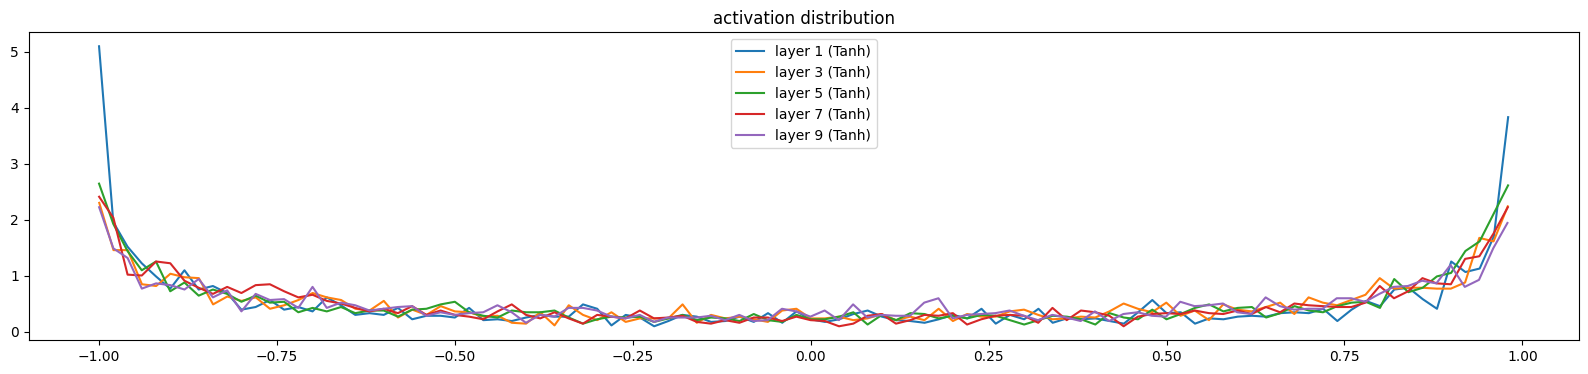

In [158]:
# они конечно уходят дальше в -1 и 1, но в целом это нормальная картина, главное они не сжимаются и не расширяются от слоя к слою
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

layer 1 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


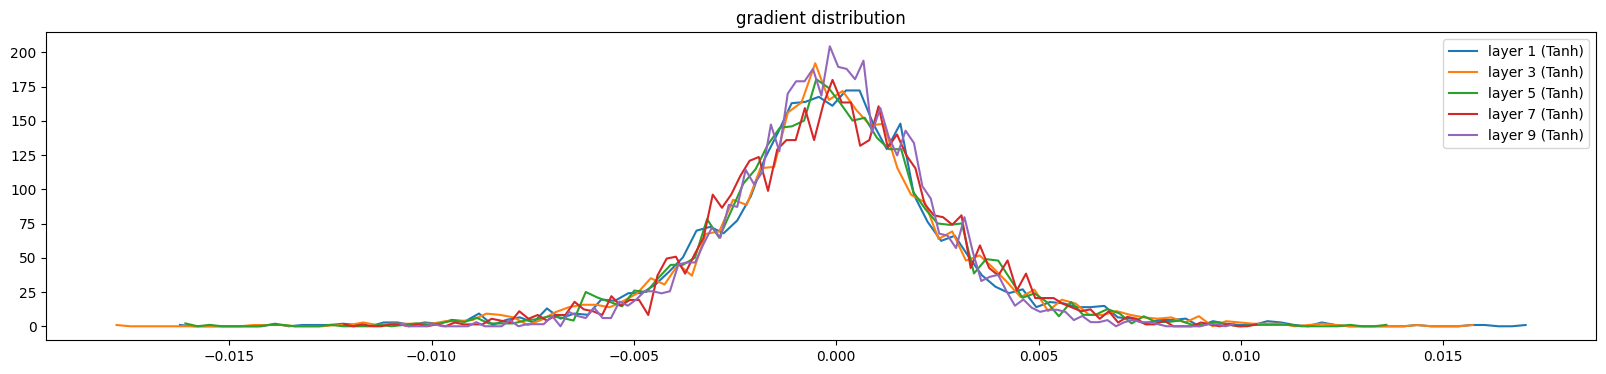

In [159]:
# все хорошо
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean +0.000772 | std 9.714616e-03 | grad:data ratio 9.714501e-03
weight  (30, 100) | mean -0.000036 | std 8.734045e-03 | grad:data ratio 2.792835e-02
weight (100, 100) | mean +0.000085 | std 7.424625e-03 | grad:data ratio 4.417370e-02
weight (100, 100) | mean +0.000055 | std 6.242011e-03 | grad:data ratio 3.681916e-02
weight (100, 100) | mean +0.000007 | std 6.161662e-03 | grad:data ratio 3.650614e-02
weight (100, 100) | mean +0.000069 | std 5.221998e-03 | grad:data ratio 3.102274e-02
weight  (100, 27) | mean +0.000000 | std 2.281147e-02 | grad:data ratio 3.229573e-01


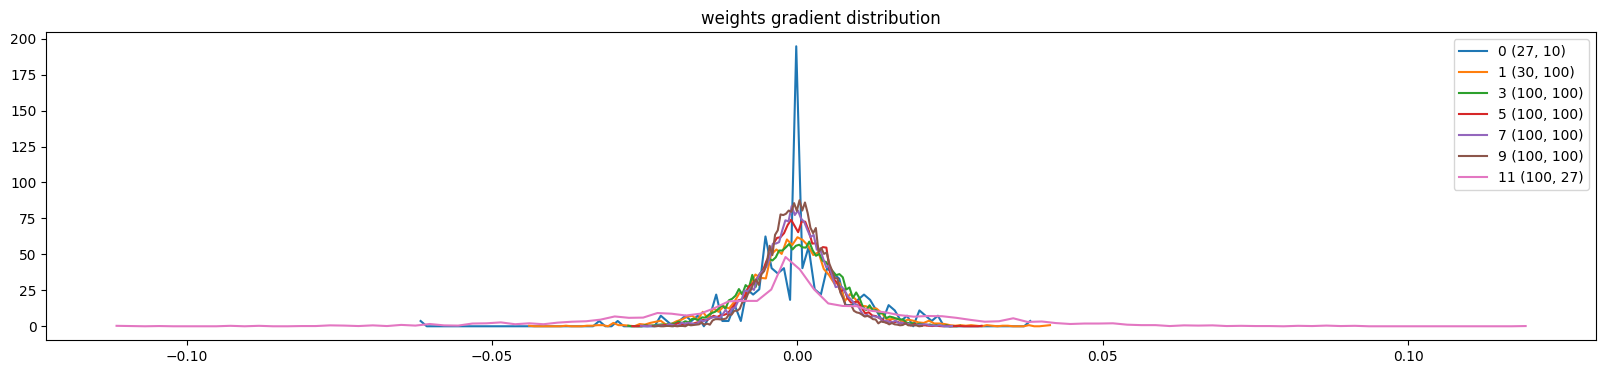

In [160]:
# видно, что в итоге они сжимаются и обучение стабилизируется
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

# Отношение update/data

In [147]:
# на самом деле, более интересно посмотреть не на отношение градиента к данным, а на отнощение величины изменения к данным

In [149]:
n_embd = 10  # размер эмбеддинга
n_hidden = 100  # число нейронов в скрытом слое сети
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1
    # ко всем остальным слоя применить нормализацию
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# такая же оптимизация как и раньше
max_steps = 200000
batch_size = 32
lossi = []
ud = []  # !!!!!!!!!!! ОТСЛЕЖИВАЕМ U/D

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    emb = C[Xb]  # получаем эмбеддинги букв
    x = emb.view(emb.shape[0], -1)  # соединяем векторы букв
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # считаем лосс

    # backward pass
    for layer in layers:
        # по умолчанию торч считает градиенты только для тензоров-листов, которым выход не является (только веса и вход)
        layer.out.retain_grad()  # позволяет считать градиент по выходу, нужно для того, чтобы посмотреть

    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # !!!!!!!!!!!!!!!! ОТСЛЕЖИВАЕМ U/D
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    # !!!!!!!!!!!!!!!! ОТСЛЕЖИВАЕМ U/D
    if i > 1000:
        break  # чтобы посмотреть

46497
      0/ 200000: 3.2962


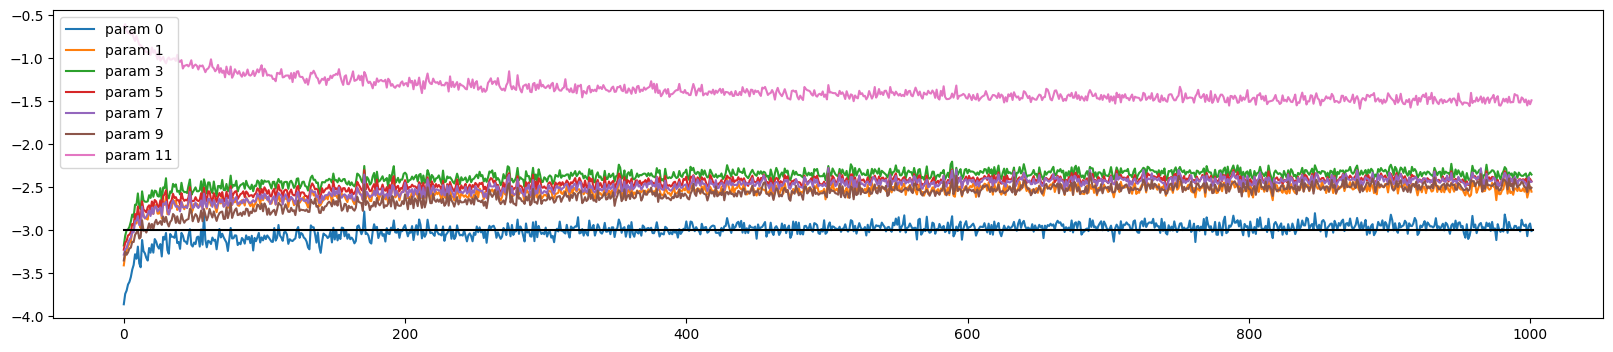

In [161]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)

plt.plot([0, len(ud)], [-3, -3], 'k')  # отношения должны быть ~1e-3
plt.legend(legends);
# обновления параметров не должны быть сильно больше чем 1e-3, если они больше - то мы обновляем параметр слишком сильно
# здесь последний слой - выброс, мы его сделали в 10 раз меньше, чтобы softmax не был сильно уверенным
# также видно, что по мере обучения значения стаблизируются
# если отношения ниже 1е-3, значит параметры не обучаются достаточно быстро

# в районе 1е-2.5 нормально, главное что стабилизируются

In [162]:
# попробуем поставить очень маленький learning rate
n_embd = 10  # размер эмбеддинга
n_hidden = 100  # число нейронов в скрытом слое сети
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1
    # ко всем остальным слоя применить нормализацию
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# такая же оптимизация как и раньше
max_steps = 200000
batch_size = 32
lossi = []
ud = []  # !!!!!!!!!!! ОТСЛЕЖИВАЕМ U/D

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    emb = C[Xb]  # получаем эмбеддинги букв
    x = emb.view(emb.shape[0], -1)  # соединяем векторы букв
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # считаем лосс

    # backward pass
    for layer in layers:
        # по умолчанию торч считает градиенты только для тензоров-листов, которым выход не является (только веса и вход)
        layer.out.retain_grad()  # позволяет считать градиент по выходу, нужно для того, чтобы посмотреть

    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.001#0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # !!!!!!!!!!!!!!!! ОТСЛЕЖИВАЕМ U/D
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    # !!!!!!!!!!!!!!!! ОТСЛЕЖИВАЕМ U/D
    if i > 1000:
        break  # чтобы посмотреть

46497
      0/ 200000: 3.2962


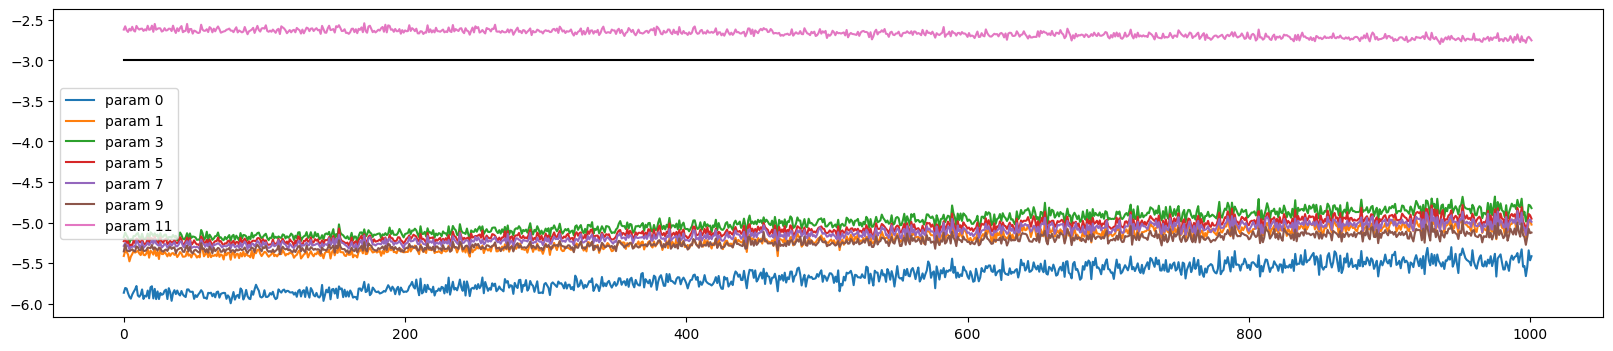

In [163]:
# график покажет, что у нас низкий lr
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)

plt.plot([0, len(ud)], [-3, -3], 'k')  # отношения должны быть ~1e-3
plt.legend(legends);
# это симптом того, что обучение через чур медленное

# ПРИМЕР
# Как узнать что что-то не так?
# Попробуем выключить нормализуцию у линейного слоя и посмотрим на графики

In [165]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)# / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

n_embd = 10  # размер эмбеддинга
n_hidden = 100  # число нейронов в скрытом слое сети
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1
    # ко всем остальным слоя применить нормализацию
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# такая же оптимизация как и раньше
max_steps = 200000
batch_size = 32
lossi = []
ud = []  # !!!!!!!!!!! ОТСЛЕЖИВАЕМ U/D

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    emb = C[Xb]  # получаем эмбеддинги букв
    x = emb.view(emb.shape[0], -1)  # соединяем векторы букв
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # считаем лосс

    # backward pass
    for layer in layers:
        # по умолчанию торч считает градиенты только для тензоров-листов, которым выход не является (только веса и вход)
        layer.out.retain_grad()  # позволяет считать градиент по выходу, нужно для того, чтобы посмотреть

    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.001#0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # !!!!!!!!!!!!!!!! ОТСЛЕЖИВАЕМ U/D
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    # !!!!!!!!!!!!!!!! ОТСЛЕЖИВАЕМ U/D
    if i > 1000:
        break  # чтобы посмотреть

46497
      0/ 200000: 3.7561


layer 1 (      Tanh): mean -0.08, std 0.95, saturated: 81.31%
layer 3 (      Tanh): mean +0.03, std 0.98, saturated: 90.38%
layer 5 (      Tanh): mean +0.03, std 0.98, saturated: 90.44%
layer 7 (      Tanh): mean +0.02, std 0.98, saturated: 90.59%
layer 9 (      Tanh): mean -0.01, std 0.98, saturated: 90.06%


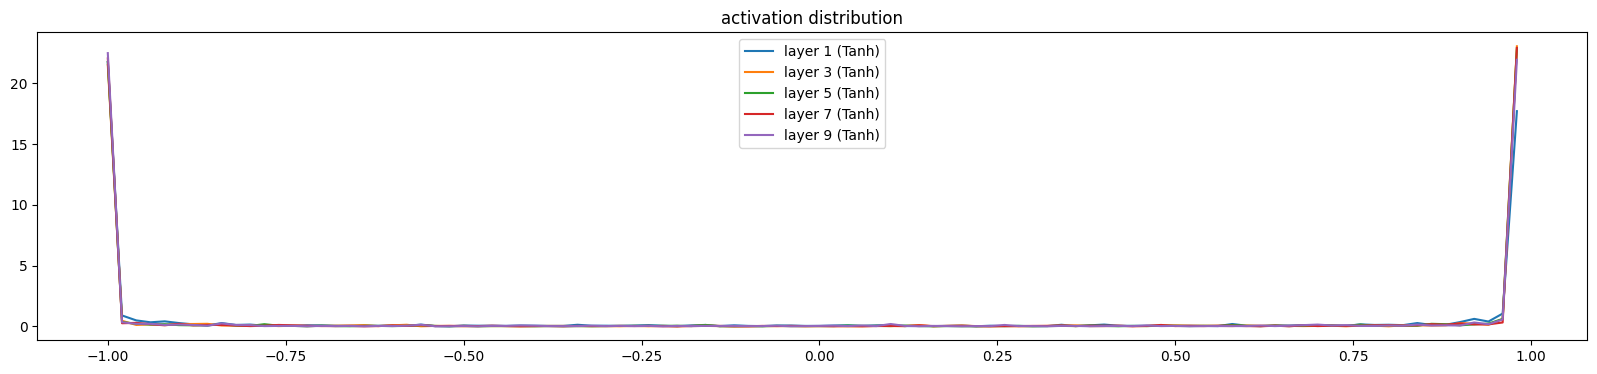

In [166]:
# ужас
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

layer 1 (      Tanh): mean -0.00, std 0.19, saturated: 0.50%
layer 3 (      Tanh): mean -0.00, std 0.07, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.02, saturated: 0.00%
layer 7 (      Tanh): mean -0.00, std 0.01, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


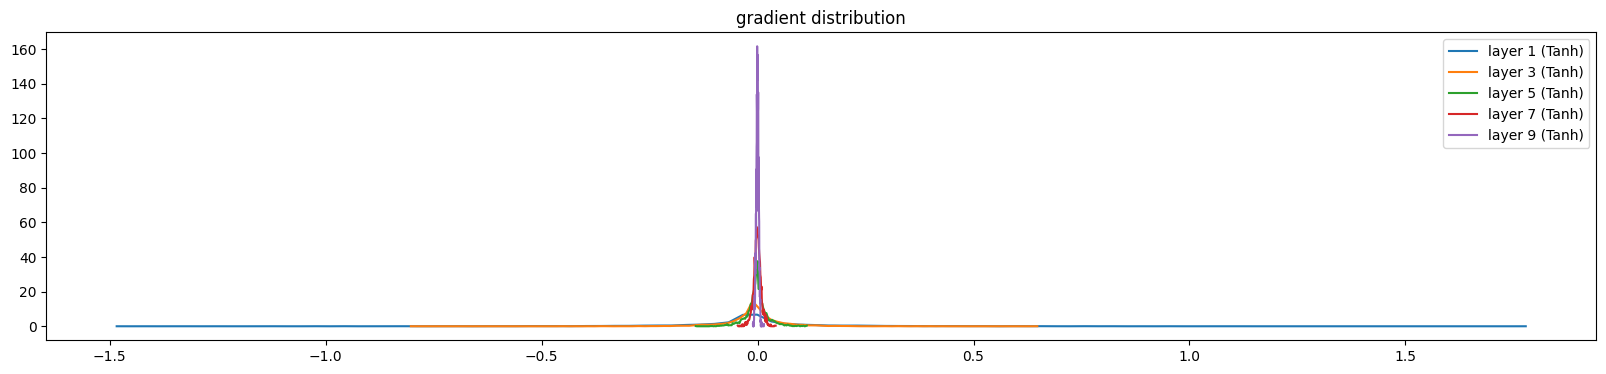

In [167]:
# кошмар
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean -0.011896 | std 1.674214e+00 | grad:data ratio 1.671335e+00
weight  (30, 100) | mean +0.003718 | std 2.465928e-01 | grad:data ratio 1.443625e-01
weight (100, 100) | mean -0.000358 | std 6.277186e-02 | grad:data ratio 3.778691e-02
weight (100, 100) | mean -0.000077 | std 2.452491e-02 | grad:data ratio 1.460824e-02
weight (100, 100) | mean -0.000089 | std 8.186581e-03 | grad:data ratio 4.896823e-03
weight (100, 100) | mean +0.000009 | std 2.954822e-03 | grad:data ratio 1.765722e-03
weight  (100, 27) | mean +0.000000 | std 3.392037e-02 | grad:data ratio 3.525123e-01


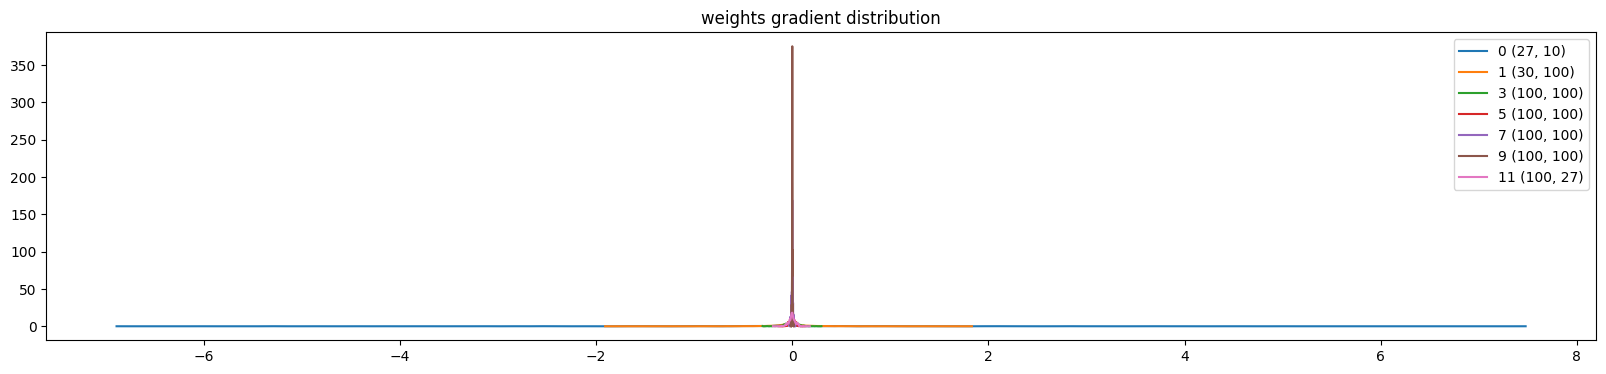

In [168]:
# треш
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

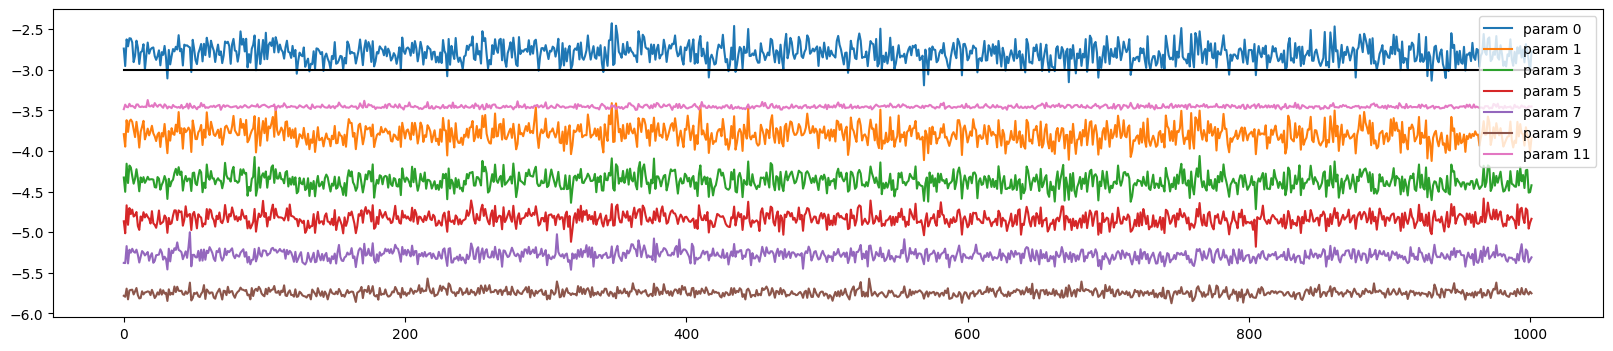

In [169]:
# все плохо
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)

plt.plot([0, len(ud)], [-3, -3], 'k')  # отношения должны быть ~1e-3
plt.legend(legends);

# Добавим BatchNorm  и посмотри как он все починит

In [7]:
n_embd = 10  # размер эмбеддинга
n_hidden = 100  # число нейронов в скрытом слое сети
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),  # обычно ставят после линейного слоя до нелинейности, но иногда меняют
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)  # можно даже поставить его после последнего слоя и все будет хорошо
]

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # ко всем остальным слоя применить нормализацию
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# такая же оптимизация как и раньше
max_steps = 200000
batch_size = 32
lossi = []
ud = []  # !!!!!!!!!!! ОТСЛЕЖИВАЕМ U/D

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    emb = C[Xb]  # получаем эмбеддинги букв
    x = emb.view(emb.shape[0], -1)  # соединяем векторы букв
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # считаем лосс

    # backward pass
    for layer in layers:
        # по умолчанию торч считает градиенты только для тензоров-листов, которым выход не является (только веса и вход)
        layer.out.retain_grad()  # позволяет считать градиент по выходу, нужно для того, чтобы посмотреть

    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # !!!!!!!!!!!!!!!! ОТСЛЕЖИВАЕМ U/D
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    # !!!!!!!!!!!!!!!! ОТСЛЕЖИВАЕМ U/D
    if i > 1000:
        break  # чтобы посмотреть

47551
      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 3.09%
layer 5 (      Tanh): mean +0.01, std 0.65, saturated: 2.38%
layer 8 (      Tanh): mean +0.00, std 0.65, saturated: 2.00%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.66, saturated: 1.38%


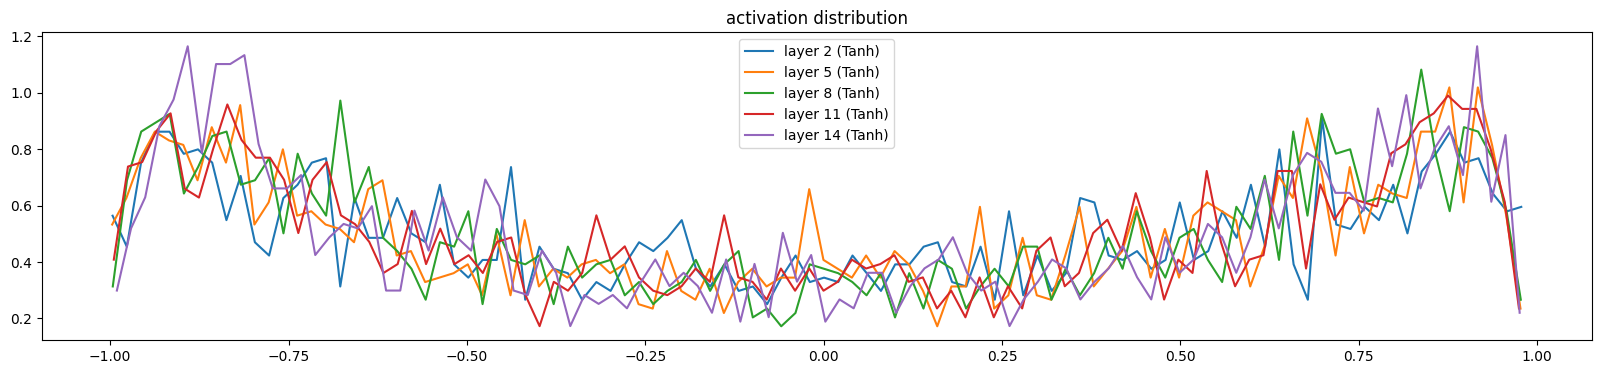

In [8]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


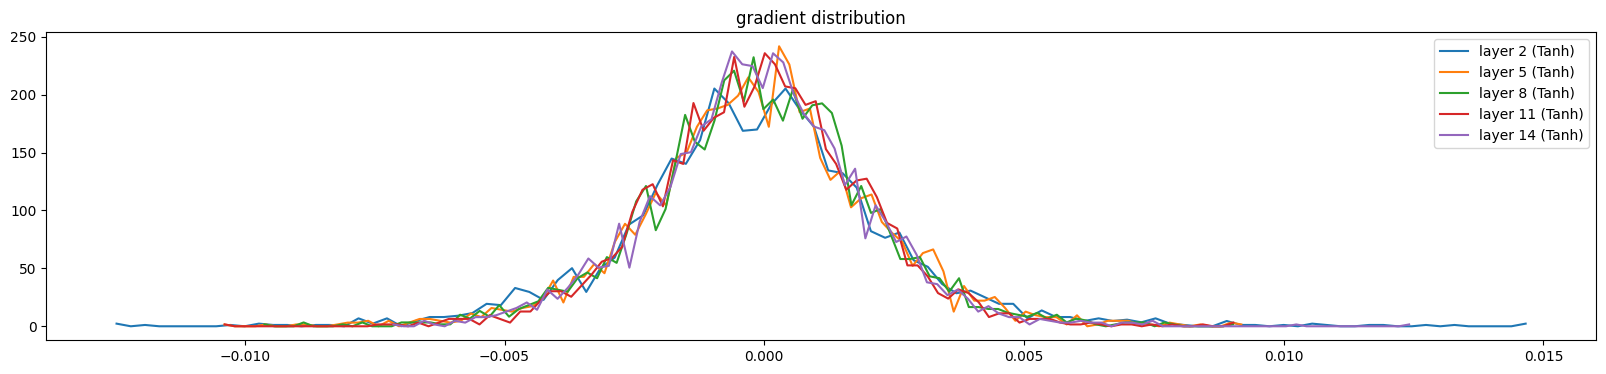

In [9]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean -0.000000 | std 6.911695e-03 | grad:data ratio 6.904882e-03
weight  (30, 100) | mean +0.000014 | std 8.957452e-03 | grad:data ratio 4.731228e-02
weight (100, 100) | mean -0.000063 | std 6.635655e-03 | grad:data ratio 6.478986e-02
weight (100, 100) | mean +0.000155 | std 5.761061e-03 | grad:data ratio 5.612592e-02
weight (100, 100) | mean -0.000043 | std 5.538545e-03 | grad:data ratio 5.431690e-02
weight (100, 100) | mean +0.000013 | std 5.438004e-03 | grad:data ratio 5.340063e-02
weight  (100, 27) | mean +0.000018 | std 1.165236e-02 | grad:data ratio 1.117657e-01


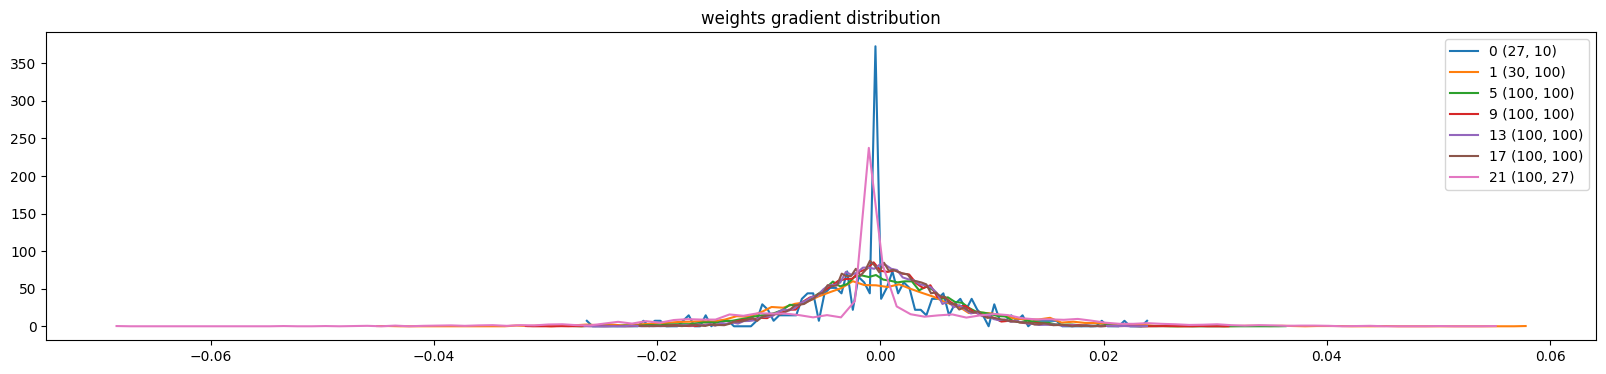

In [10]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

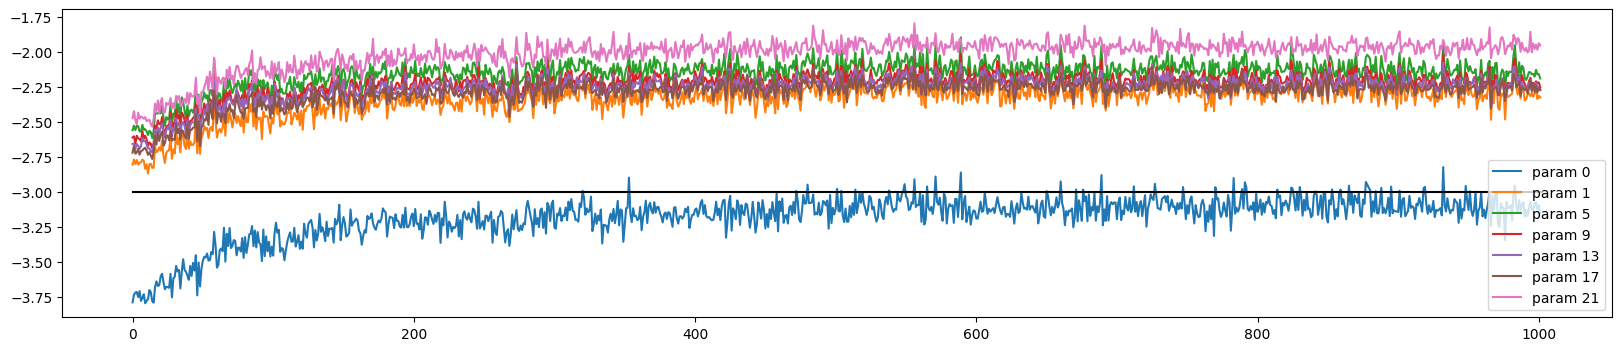

In [11]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)

plt.plot([0, len(ud)], [-3, -3], 'k')  # отношения должны быть ~1e-3
plt.legend(legends);

In [220]:
# можно пробовать менять инициализации по разному и убедиться, что активации тангенсов и градиенты будут впорядке
# единственное что возможно нужно будет менять lr